# **2017 Full-field Data, Treatment V**
***Objective:* perform NMF and highlight contributions of NMF-resulting components in each sample for across-sample comparison**

## Treatment Va:
***Objective:* produce spectral components as derived from NMF applied to H-750 raw pigment samples**

## Treatment Vb:
***Objective:* produce pairplot of coefficients for NMF components of each sample after applying model**

## Treatment Vc:
***Objective:* produce images based on NMF results to demonstrate heterogeneity within and between raw pigment samples**

## Treatment Vd:
***Objective:* produce spectra stepping across individual particles to demonstrate in-particle homogeneity, selected based on NMF images**

### Program: 
[Jupyter notebook 5.5.0, Python 3.6.5]

### Input: 
- normalized full-field XANES spectral cubes, type = .hdf5, [dataset22] ()
> H020_norm.hdf <br> H415_norm.hdf <br> H600_norm.hdf <br> H750_norm.hdf <br> H020oilL4_norm <br> H750oilL4_norm

- mask images, type = .png, [dataset24] ()
> mask_mean_value_H020_norm_date.png <br>
mask_mean_value_H415_norm_date.png <br> 
mask_mean_value_600Vpow_1_date.png <br> 
mask_mean_value_H750_norm_date.png <br>
mask_mean_value_H020oilL4_norm_date.png <br>
mask_mean_value_H750oilL4_norm_date.png <br>


### Steps:
- follow script below

### Output:

#### Treatment Va:
- NMF components, type = .svg or .pdf, [dataset26] ()
> NMF_H750fit_3components_date_0.pdf

#### Treatment Vb:
- NMF components, type = .png (dpi = 600), [dataset27] ()
> NMF_H750fit_com_of_3_date_0.png <br>
NMFoil_H750fit_com_of_3_date_0.png <br>
NMFhist_H750fit_com_of_3_date_0.png <br>


#### Treatment Vc:
- falsed-colored images based on NMF components, type = .svg or .pdf, [dataset28] ()
> H750_norm_diff31_of_3_date_0.svg <br> 
H650_norm_diff31_of_3_date_0.svg <br> 
H415_norm_diff31_of_3_date_0.svg <br> 
H020_norm_diff31_of_3_date_0.svg <br> 
H750oilL4_norm_diff31_of_3_date_0.svg <br> 
H020oilL4_norm_diff31_of_3_date_0.svg

#### Treatment Vd:
- spectra per particle, type = .svg or .pdf [dataset29] ()
> spec_H750_norm_diff31_of_3_date_0.svg <br> 
spec_H650_norm_diff31_of_3_date_0.svg <br> 
spec_H415_norm_diff31_of_3_date_0.svg <br> 
spec_H020_norm_diff31_of_3_date_0.svg <br> 

> H750_norm_1st_date_cursors_um_0 <br>
H750_norm_2nd_date_cursors_um_0.svg <br>
H750_norm_3rd_date_cursors_um_0.svg <br>
H750_norm_4th_date_cursors_um_0.svg <br>
H600_norm_1st_date_cursors_um_0.svg <br>
H600_norm_2nd_date_cursors_um_0.svg <br>
H415_norm_1st_date_cursors_um_0.svg <br>
H415_norm_2nd_date_cursors_um_0.svg <br>
H020_norm_1st_date_cursors_um_0.svg <br>
H020_norm_2nd_date_cursors_um_0.svg <br>

### Notes:
- all comments are made with '##' 
- aspects that can be changed depending on the sample, etc. are with '#'

### Additional Notes:
- NMF model fit on H-750
- model applied to all samples
- NMF left- and right- bounds chosen to focus on 'envelope'
    - left-bound = **index 10** (ie **2467.60 eV**)
    - right-bound = **index 50** (ie **2475.60 eV**)
- adjusted output images from pixel-by-pixel to microns based on imaging objective for full-field acquisition
    - multiplied pixels by 0.7 micron/pixel

In [85]:
%pylab inline
import tables
import imageio
import numpy as np
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import NMF

Populating the interactive namespace from numpy and matplotlib


/mntdirect/_data_id21_inhouse/wout/gambardella/rhapsody-in-blue/.virtualenvs/py34/lib/python3.4/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['colors']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
##standards for figures
SMALL_SIZE = 24
MEDIUM_SIZE = 24
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
figsize(16, 16)

In [3]:
##prepare output
date = datetime.datetime.now().strftime("%Y%m%d")
for i in [26, 27, 28, 29]:
    try:
        os.mkdir('dataset_'+str(i))
    except OSError:
        pass

Start here for each new file import...

## Treatment Va:

In [4]:
##preparation for importing all normalized files from raw pigment
filenames = ['H750_norm.hdf',  ##for 750 C sample
             'H600_norm.hdf',  ##for 600 C sample
             'H415_norm.hdf',  ##for 415 C sample
             'H020_norm.hdf',  ##for 20 C sample
             'H750oilL4_norm.hdf',  ##for 750 C in oil aged sample
             'H020oilL4_norm.hdf']  ##for 20 C in oil aged sample
filenames = [os.path.join('dataset_22', filename) for filename in filenames]
h5files = [tables.open_file(filename) for filename in filenames]
h5_7, h5_6, h5_4, h5_2, h5_7L, h5_2L = h5files

In [5]:
##preparation for saving
basenames = [os.path.splitext(os.path.basename(filename))
             for filename in filenames]
for basename, ext in basenames:
    print(basename, ext)
basename_7, basename_6, basename_4, basename_2, basename_7L, basename_2L = list(zip(*basenames))[0]

H750_norm .hdf
H600_norm .hdf
H415_norm .hdf
H020_norm .hdf
H750oilL4_norm .hdf
H020oilL4_norm .hdf


In [6]:
##importing all normalized files
data_7 = h5_7.root.data[:] ##for normalized data, hdf
print(data_7.shape, data_7.dtype)  ##want (energy, spatial 1, spatial 2)

data_6 = h5_6.root.data[:].transpose(2, 0, 1) ##for normalized data, hdf; transpose because this file is in different order
print(data_6.shape, data_6.dtype)  ##want (energy, spatial 1, spatial 2)

data_4 = h5_4.root.data[:] ##for normalized data, hdf
print(data_4.shape, data_4.dtype)  ##want (energy, spatial 1, spatial 2)

data_2 = h5_2.root.data[:] ##for normalized data, hdf
print(data_2.shape, data_2.dtype)  ##want (energy, spatial 1, spatial 2)

data_7L = h5_7L.root.data[:] ##for normalized data, hdf
print(data_7L.shape, data_7L.dtype)  ##want (energy, spatial 1, spatial 2)

data_2L = h5_2L.root.data[:] ##for normalized data, hdf
print(data_2L.shape, data_2L.dtype)  ##want (energy, spatial 1, spatial 2)

(140, 1520, 2020) float32
(140, 2148, 1796) float32
(140, 2179, 1720) float32
(140, 1720, 1670) float32
(140, 1420, 1720) float32
(140, 1520, 1520) float32


In [7]:
##taking the mean over all energies
mn_7 = data_7.mean(axis=0)
mn_6 = data_6.mean(axis=0)
mn_4 = data_4.mean(axis=0)
mn_2 = data_2.mean(axis=0)

mn_7L = data_7L.mean(axis=0)
mn_2L = data_2L.mean(axis=0)

##example
# imshow(mn_7)
# colorbar()

Move to folder where mask file is...

In [88]:
##enter date of mask file... (None means last date)
mask_selection = [(basename_7, None),
                  ('600Vpow_1', None),
                  (basename_4, None),
                  (basename_2, None),
                  (basename_7L, None),
                  (basename_2L, None)]
mask_files = [glob(os.path.join('dataset_24',
              'mask_mean_value_{}_{}.png'.format(mask_name, (mask_date if mask_date else '*'))))[-1]
              for mask_name, mask_date in mask_selection]

fname_7, fname_6, fname_4, fname_2, fname_7L, fname_2L = mask_files
for fname in mask_files:
    print(fname)

dataset_24/mask_mean_value_H750_norm_20190328.png
dataset_24/mask_mean_value_600Vpow_1_20190702.png
dataset_24/mask_mean_value_H415_norm_20190328.png
dataset_24/mask_mean_value_H020_norm_20190328.png
dataset_24/mask_mean_value_H750oilL4_norm_20190328.png
dataset_24/mask_mean_value_H020oilL4_norm_20190328.png


In [9]:
##reading in the mask for the filenames above
mask_7 = imageio.imread(fname_7)
print(mask_7.shape)

mask_6 = imageio.imread(fname_6)
print(mask_6.shape)

mask_4 = imageio.imread(fname_4)
print(mask_4.shape)

mask_2 = imageio.imread(fname_2)
print(mask_2.shape)

mask_7L = imageio.imread(fname_7L)
print(mask_7L.shape)

mask_2L = imageio.imread(fname_2L)
print(mask_2L.shape)

(1520, 2020, 4)
(2148, 1796, 4)
(2179, 1720, 4)
(1720, 1670, 4)
(1420, 1720, 4)
(1520, 1520, 4)


uint8


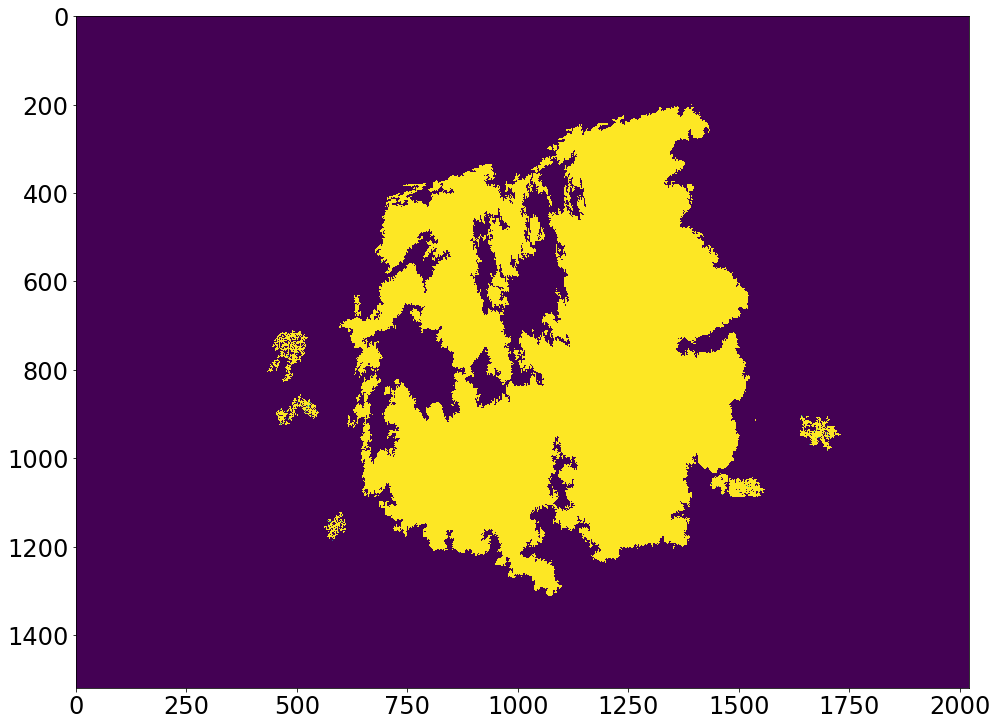

In [10]:
##just to see...
print(mask_7.dtype)
tmp = imshow(mask_7[...,-1])

uint8


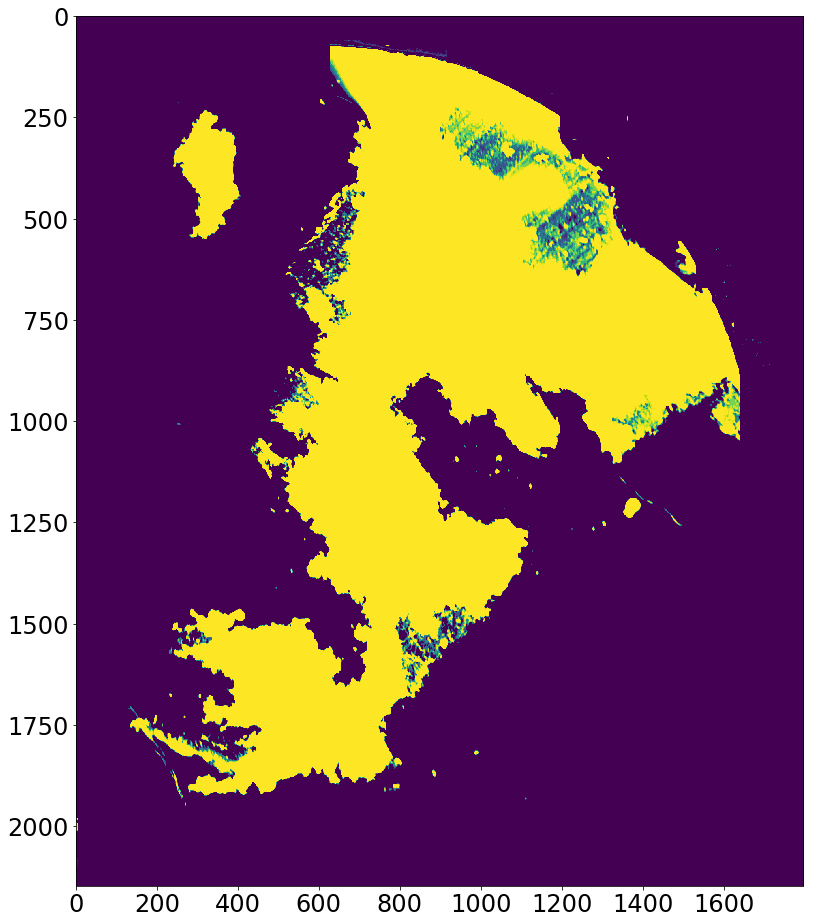

In [11]:
##just to see...
print(mask_6.dtype)
tmp = imshow(mask_6[...,-1])

uint8


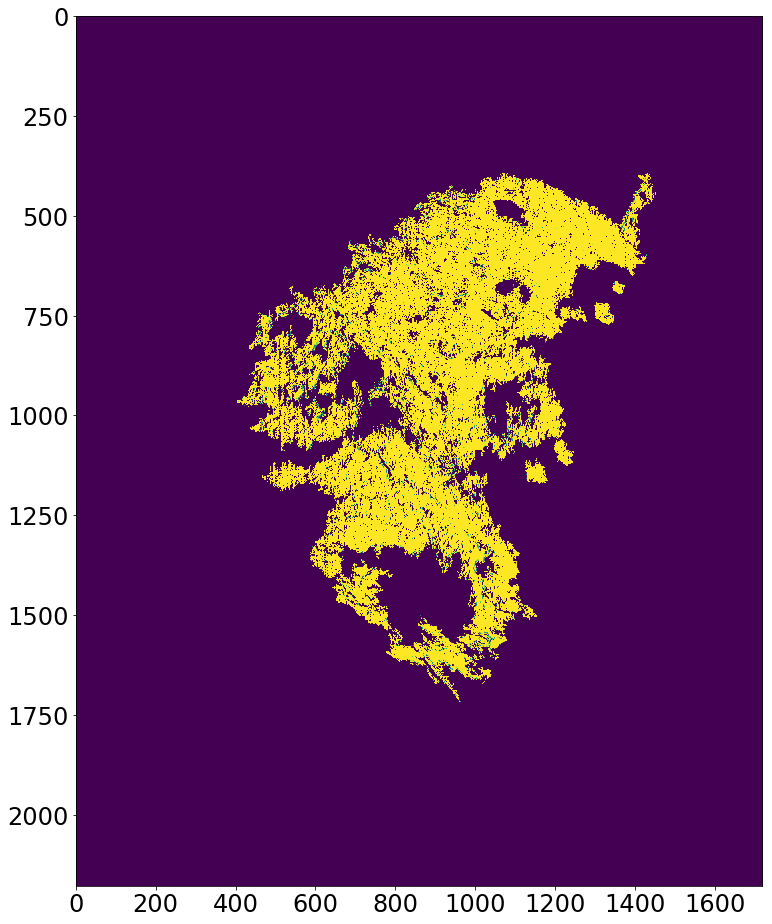

In [12]:
##just to see...
print(mask_4.dtype)
tmp = imshow(mask_4[...,-1])

uint8


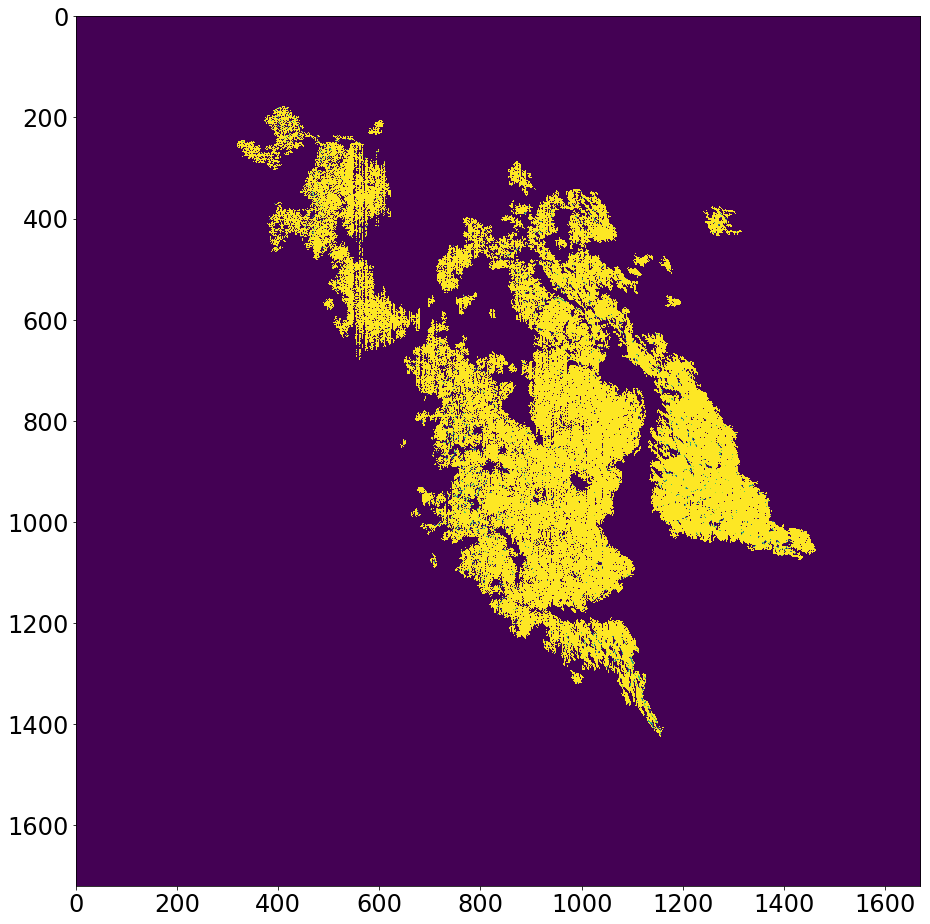

In [13]:
##just to see...
print(mask_2.dtype)
tmp = imshow(mask_2[...,-1])

uint8


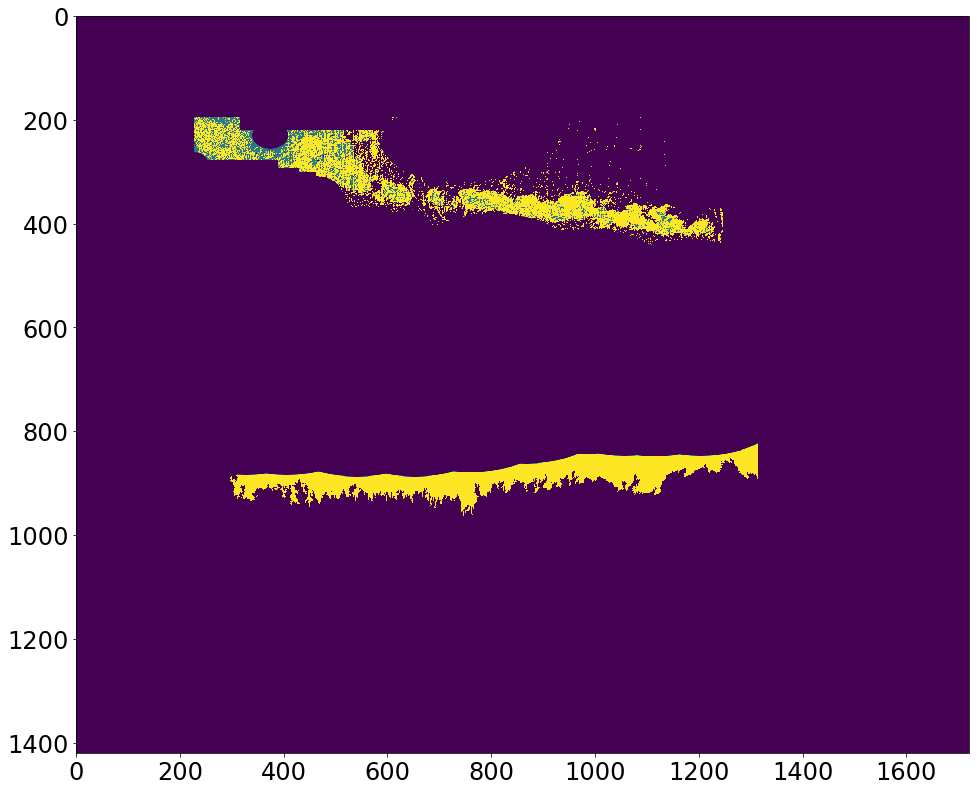

In [14]:
##just to see...
print(mask_7L.dtype)
tmp = imshow(mask_7L[...,-1])

uint8


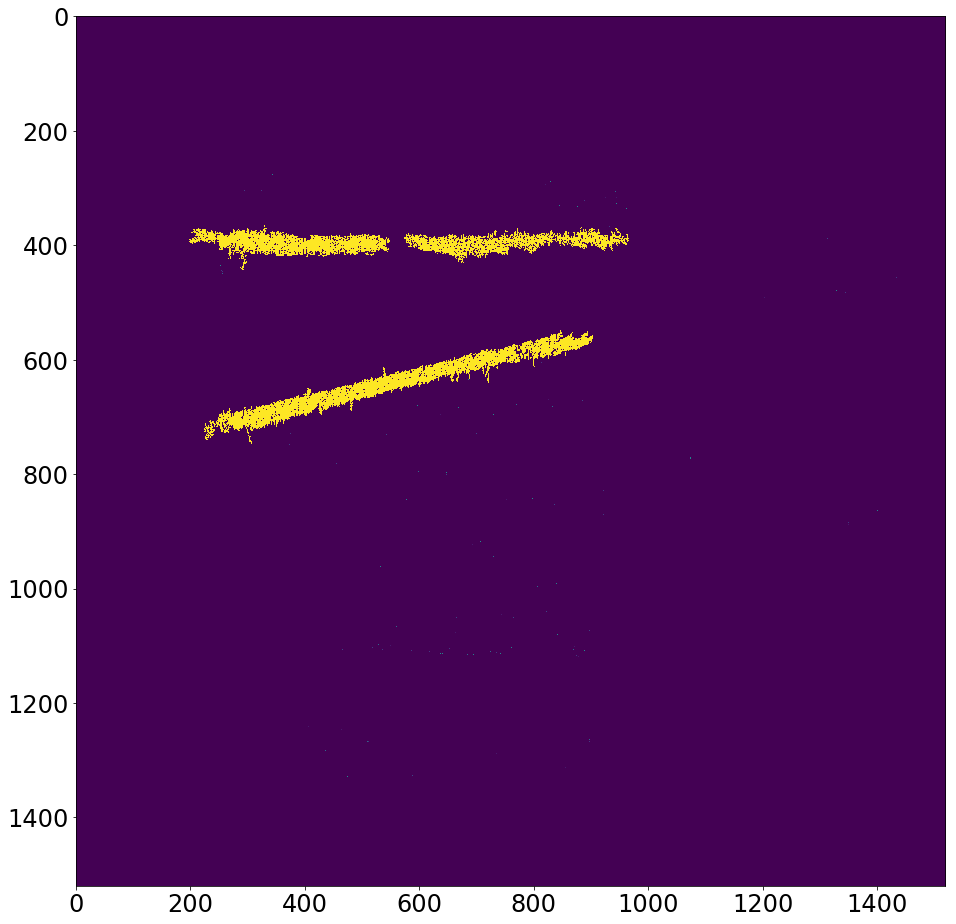

In [15]:
##just to see...
print(mask_2L.dtype)
tmp = imshow(mask_2L[...,-1])

In [16]:
##preparing as 8-bit
mask_7[...,-1].max(), mask_7[...,-1].min() 
mask_6[...,-1].max(), mask_6[...,-1].min() 
mask_4[...,-1].max(), mask_4[...,-1].min() 
mask_2[...,-1].max(), mask_2[...,-1].min() 
mask_7L[...,-1].max(), mask_7L[...,-1].min() 
mask_2L[...,-1].max(), mask_2L[...,-1].min() 

(255, 0)

In [17]:
##making a boolean matrix for the last channel (-1, transparency) of the alpha channel where the value is >128
##128, because it's 8 bit, so 0 to 255 and 128 is halfway, so weaker signal assume is 0, and stronger signal assume is 1
wanted_7 = mask_7[...,-1] > 128
print(wanted_7.dtype)

wanted_6 = mask_6[...,-1] > 128
print(wanted_6.dtype)

wanted_4 = mask_4[...,-1] > 128
print(wanted_4.dtype)

wanted_2 = mask_2[...,-1] > 128
print(wanted_2.dtype)

wanted_7L = mask_7L[...,-1] > 128
print(wanted_7L.dtype)

wanted_2L = mask_2L[...,-1] > 128
print(wanted_2L.dtype)

bool
bool
bool
bool
bool
bool


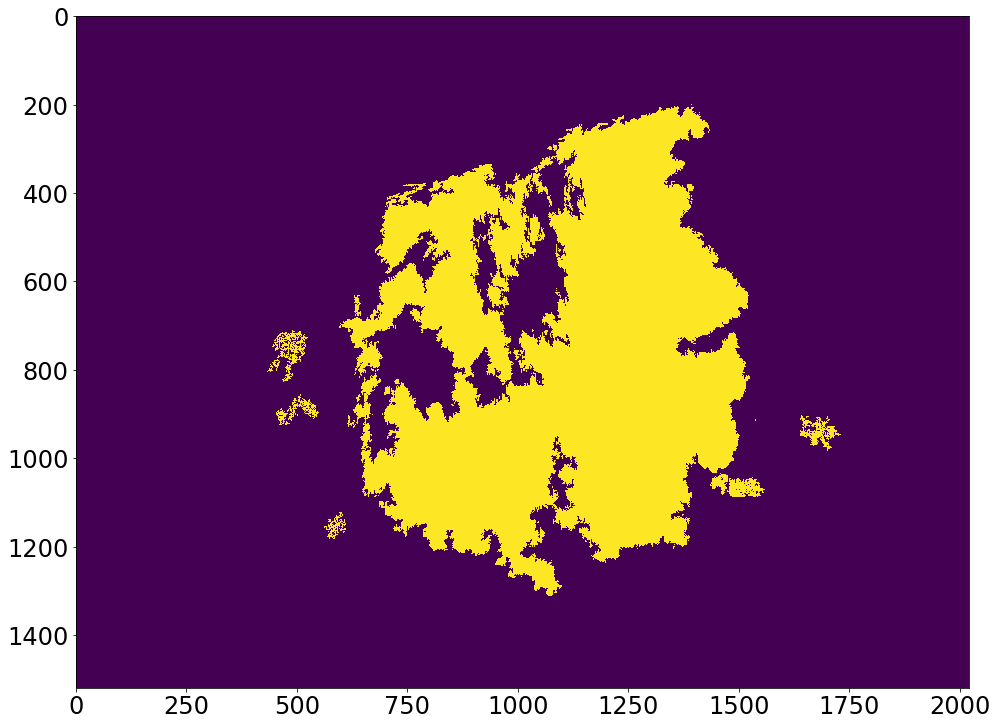

In [18]:
##only the particles, just to see...
tmp = imshow(wanted_7)
#tmp = imshow(wanted_6)
#tmp = imshow(wanted_4)
#tmp = imshow(wanted_2)
#tmp = imshow(wanted_7L)
#tmp = imshow(wanted_2L)

In [19]:
##need mask and normalized data to be aligned, check shapes
##if first two dimensions (ie spatial dimensions) do not match, fix with transpose
##for all normalized files, must perform transpose in next cell

print(wanted_7.shape)
print(data_7.shape) ##output shows it is energy x spatial 1 x spatial 2

print(wanted_6.shape)
print(data_6.shape) ##output shows it is energy x spatial 1 x spatial 2

print(wanted_4.shape)
print(data_4.shape) ##output shows it is energy x spatial 1 x spatial 2

print(wanted_2.shape)
print(data_2.shape) ##output shows it is energy x spatial 1 x spatial 2

print(wanted_7L.shape)
print(data_7L.shape) ##output shows it is energy x spatial 1 x spatial 2

print(wanted_2L.shape)
print(data_2L.shape) ##output shows it is energy x spatial 1 x spatial 2

(1520, 2020)
(140, 1520, 2020)
(2148, 1796)
(140, 2148, 1796)
(2179, 1720)
(140, 2179, 1720)
(1720, 1670)
(140, 1720, 1670)
(1420, 1720)
(140, 1420, 1720)
(1520, 1520)
(140, 1520, 1520)


In [20]:
##transposes so shapes are aligned
d_7 = data_7.transpose(1, 2, 0)
print(d_7.shape)  ##should match 'wanted' now for first two dimensions

d_6 = data_6.transpose(1, 2, 0)
print(d_6.shape)  ##should match 'wanted' now for first two dimensions

d_4 = data_4.transpose(1, 2, 0)
print(d_4.shape)  ##should match 'wanted' now for first two dimensions

d_2 = data_2.transpose(1, 2, 0)
print(d_2.shape)  ##should match 'wanted' now for first two dimensions

d_7L = data_7L.transpose(1, 2, 0)
print(d_7L.shape)  ##should match 'wanted' now for first two dimensions

d_2L = data_2L.transpose(1, 2, 0)
print(d_2L.shape)  ##should match 'wanted' now for first two dimensions

(1520, 2020, 140)
(2148, 1796, 140)
(2179, 1720, 140)
(1720, 1670, 140)
(1420, 1720, 140)
(1520, 1520, 140)


In [21]:
##selects all values in d that match wanted requirements, so all spectra whose mean gave an intensity >128 in image
wanted_data_7 = d_7[wanted_7]
print(wanted_data_7.shape)   ##(number of spectra meeting requirement, # of energies measured)

wanted_data_6 = d_6[wanted_6]
print(wanted_data_6.shape)  

wanted_data_4 = d_4[wanted_4]
print(wanted_data_4.shape)  

wanted_data_2 = d_2[wanted_2]
print(wanted_data_2.shape)  

wanted_data_7L = d_7L[wanted_7L]
print(wanted_data_7L.shape)   

wanted_data_2L = d_2L[wanted_2L]
print(wanted_data_2L.shape)  

(585062, 140)
(1072361, 140)
(466320, 140)
(312653, 140)
(82444, 140)
(36431, 140)


Go to directory where energy axis file is...

In [22]:
##import energy values
filename = os.path.join('dataset_x', 'H020_energy_1.csv')
kenergy = pd.read_csv(filename, delimiter=',', header = None).values
kenergy.shape

(140, 1)

In [23]:
##convert units from keV to eV
energy = kenergy *1000
energy

array([[2460.06989479],
       [2460.8900547 ],
       [2461.99011803],
       [2463.00005913],
       [2463.99998665],
       [2464.99991417],
       [2466.00008011],
       [2467.00000763],
       [2467.20004082],
       [2467.40007401],
       [2467.60010719],
       [2467.79990196],
       [2467.99993515],
       [2468.19996834],
       [2468.40000153],
       [2468.60003471],
       [2468.8000679 ],
       [2469.00010109],
       [2469.19989586],
       [2469.39992905],
       [2469.59996223],
       [2469.79999542],
       [2470.00002861],
       [2470.2000618 ],
       [2470.40009499],
       [2470.59988976],
       [2470.79992294],
       [2470.99995613],
       [2471.19998932],
       [2471.40002251],
       [2471.60005569],
       [2471.80008888],
       [2471.99988365],
       [2472.19991684],
       [2472.39995003],
       [2472.59998322],
       [2472.8000164 ],
       [2473.00004959],
       [2473.20008278],
       [2473.40011597],
       [2473.59991074],
       [2473.799

In [24]:
##the energy range over which the NMF will be performed, just to see...

##lower energy bound
print(energy[10])

##upper energy bound
print(energy[50])

[2467.60010719]
[2475.6000042]


Change directory to where you want to save NMF results

In [25]:
##standards for publication figures
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Applying NMF to all data, model fit on H-750 data

In [26]:
##energies of interest
print(energy[10])
print(energy[50])

[2467.60010719]
[2475.6000042]


In [27]:
##cutting data to include only energy range of interest
cut_data_7 = wanted_data_7[:,10:50]
print(cut_data_7.shape)

cut_data_6 = wanted_data_6[:,10:50]
print(cut_data_6.shape)

cut_data_4 = wanted_data_4[:,10:50]
print(cut_data_4.shape)

cut_data_2 = wanted_data_2[:,10:50]
print(cut_data_2.shape)


cut_data_7L = wanted_data_7L[:,10:50]
print(cut_data_7L.shape)

cut_data_2L = wanted_data_2L[:,10:50]
print(cut_data_2L.shape)

(585062, 40)
(1072361, 40)
(466320, 40)
(312653, 40)
(82444, 40)
(36431, 40)


In [28]:
##make all negative values equal to zero, negative values are meaningless in the XANES spectral data
cut_data_7[cut_data_7<0] = 0
cut_data_6[cut_data_6<0] = 0
cut_data_4[cut_data_4<0] = 0
cut_data_2[cut_data_2<0] = 0

cut_data_7L[cut_data_7L<0] = 0
cut_data_2L[cut_data_2L<0] = 0

In [29]:
##select number of components for NMF
Nn = 3

##performing NMF, fit model on H-750 data
model = NMF(n_components = Nn, init = 'random', random_state = 0)
model.fit(cut_data_7)
H = model.components_  ##components

##transform all data using model fit from H-750 data
W7 = model.transform(cut_data_7)  ##coefficients
W6 = model.transform(cut_data_6)
W4 = model.transform(cut_data_4)
W2 = model.transform(cut_data_2)

W7L = model.transform(cut_data_7L)
W2L = model.transform(cut_data_2L)

In [30]:
##resulting data shapes
print(W7.shape)
print(W6.shape)
print(W4.shape)
print(W2.shape)
print(W7L.shape)
print(W2L.shape)
print(H.shape)

(585062, 3)
(1072361, 3)
(466320, 3)
(312653, 3)
(82444, 3)
(36431, 3)
(3, 40)


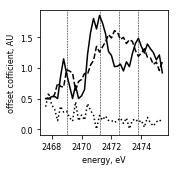

In [33]:
##overlay plot of components
plt.figure(figsize=(2.3,2.3))

plt.plot(energy[10:50], H.T[:,0]+0.5, 'k' )
plt.plot(energy[10:50], H.T[:,1], 'k:')
plt.plot(energy[10:50], H.T[:,2]+0.5, 'k--' )


H0 = 2469.0
H1 = 2471.2
H2 = 2472.5
H3 = 2473.8

axvline(H0, linewidth = 0.5, color = 'k', linestyle = '--')
axvline(H1, linewidth = 0.5, color = 'k', linestyle = '--')
axvline(H2, linewidth = 0.5, color = 'k', linestyle = '--')
axvline(H3, linewidth = 0.5, color = 'k', linestyle = '--')

plt.xlabel('energy, eV')
plt.ylabel('offset cofficient, AU')


#saving NMF overlay as a pdf and svg
savefmt = os.path.join('dataset_26',
                       '{}{}{}{}{{:d}}.{{}}'.format('NMF_H750fit_', Nn, 'components_', date, '_'))
i = 0
while os.path.exists(savefmt.format(i, 'pdf')):
    i += 1
plt.savefig(savefmt.format(i, 'pdf'), bbox_inches = 'tight')
plt.savefig(savefmt.format(i, 'svg'), bbox_inches = 'tight')

## Treatment Vb:

In [34]:
df_W7 = pd.DataFrame(W7)
df_W7.columns = ['W1', 'W2', 'W3']
df_W7['cat'] = 'H750'

df_W6 = pd.DataFrame(W6)
df_W6.columns = ['W1', 'W2', 'W3']
df_W6['cat'] = 'H600'

df_W4 = pd.DataFrame(W4)
df_W4.columns = ['W1', 'W2', 'W3']
df_W4['cat'] = 'H415'

df_W2 = pd.DataFrame(W2)
df_W2.columns = ['W1', 'W2', 'W3']
df_W2['cat'] = 'H020'

df_W7L = pd.DataFrame(W7L)
df_W7L.columns = ['W1', 'W2', 'W3']
df_W7L['cat'] = 'H750oilL4'

df_W2L = pd.DataFrame(W2L)
df_W2L.columns = ['W1', 'W2', 'W3']
df_W2L['cat'] = 'H020oilL4'

df_all = pd.concat([df_W7.iloc[::2000,:],
                    df_W6.iloc[::2000,:],
                    df_W4.iloc[::2000,:],
                    df_W2.iloc[::2000,:]], axis =0)

df_all

W1        W2        W3   cat
0       0.888110  0.381152  0.062346  H750
2000    0.728603  0.362873  0.760877  H750
4000    1.191022  0.685170  1.261615  H750
6000    0.673646  0.264811  0.721368  H750
8000    0.770086  0.034434  0.603119  H750
10000   0.000000  0.000000  0.000000  H750
12000   0.387052  0.028741  0.431285  H750
14000   0.414725  0.103644  0.721356  H750
16000   0.586620  0.081075  0.368685  H750
18000   0.000000  0.000000  0.000000  H750
20000   0.692853  0.111124  0.475812  H750
22000   0.608936  0.134362  0.582906  H750
24000   0.000000  0.000000  0.000000  H750
26000   0.000000  0.000000  0.000000  H750
28000   0.963686  0.057024  0.511654  H750
30000   0.000000  0.000000  0.000000  H750
32000   0.637570  0.032085  0.490812  H750
34000   1.024182  0.246583  0.432250  H750
36000   0.499261  0.150381  0.507234  H750
38000   0.000000  0.000000  0.000000  H750
40000   0.800322  0.000000  0.716309  H750
42000   0.000000  0.000000  0.000000  H750
44000   0.000000  0.000000  0.000000  H750
46000   0.523604  0.000000  0.375726  H750
48000   0.779416  0.134399  0.259662  H750
50000   0.319364  0.343646  0.543386  H750
52000   0.747535  0.097183  0.362896  H750
54000   0.600333  0.008740  0.438726  H750
56000   0.316115  0.000000  0.344796  H750
58000   0.000000  0.000000  0.000000  H750
...          ...       ...       ...   ...
254000  0.376916  0.000000  1.031728  H020
256000  0.252003  0.080077  1.355923  H020
258000  0.465154  0.227273  0.982421  H020
260000  0.149876  0.370822  1.127085  H020
262000  0.496743  0.000000  1.433568  H020
264000  0.056170  0.000000  1.078347  H020
266000  0.019094  0.006390  0.814546  H020
268000  0.265397  0.472208  1.234294  H020
270000  0.218618  0.009027  1.377730  H020
272000  0.150781  0.010841  1.215448  H020
274000  0.308524  0.355357  0.997626  H020
276000  0.204173  0.172496  0.986252  H020
278000  0.255332  0.205673  0.980849  H020
280000  0.237278  0.092314  1.016722  H020
282000  0.203790  0.331738  0.815117  H020
284000  0.275550  0.085537  1.009189  H020
286000  0.266547  0.308405  1.307334  H020
288000  0.172404  0.000000  1.113246  H020
290000  0.209219  0.199550  1.349549  H020
292000  0.331429  0.054062  1.208743  H020
294000  0.264169  0.102565  0.809025  H020
296000  0.208063  0.000000  0.872197  H020
298000  0.218499  0.000000  1.144569  H020
300000  0.285150  0.005667  0.818045  H020
302000  0.211859  0.104440  0.939892  H020
304000  0.188331  0.000000  1.049022  H020
306000  0.205678  0.200589  1.086807  H020
308000  0.477488  0.207077  0.579282  H020
310000  0.187997  0.000000  0.494132  H020
312000  0.216852  0.295903  0.495928  H020

[1221 rows x 4 columns]

In [35]:
df_all.cat = df_all.cat.astype('category')
df_all.dtypes

W1      float64
W2      float64
W3      float64
cat    category
dtype: object

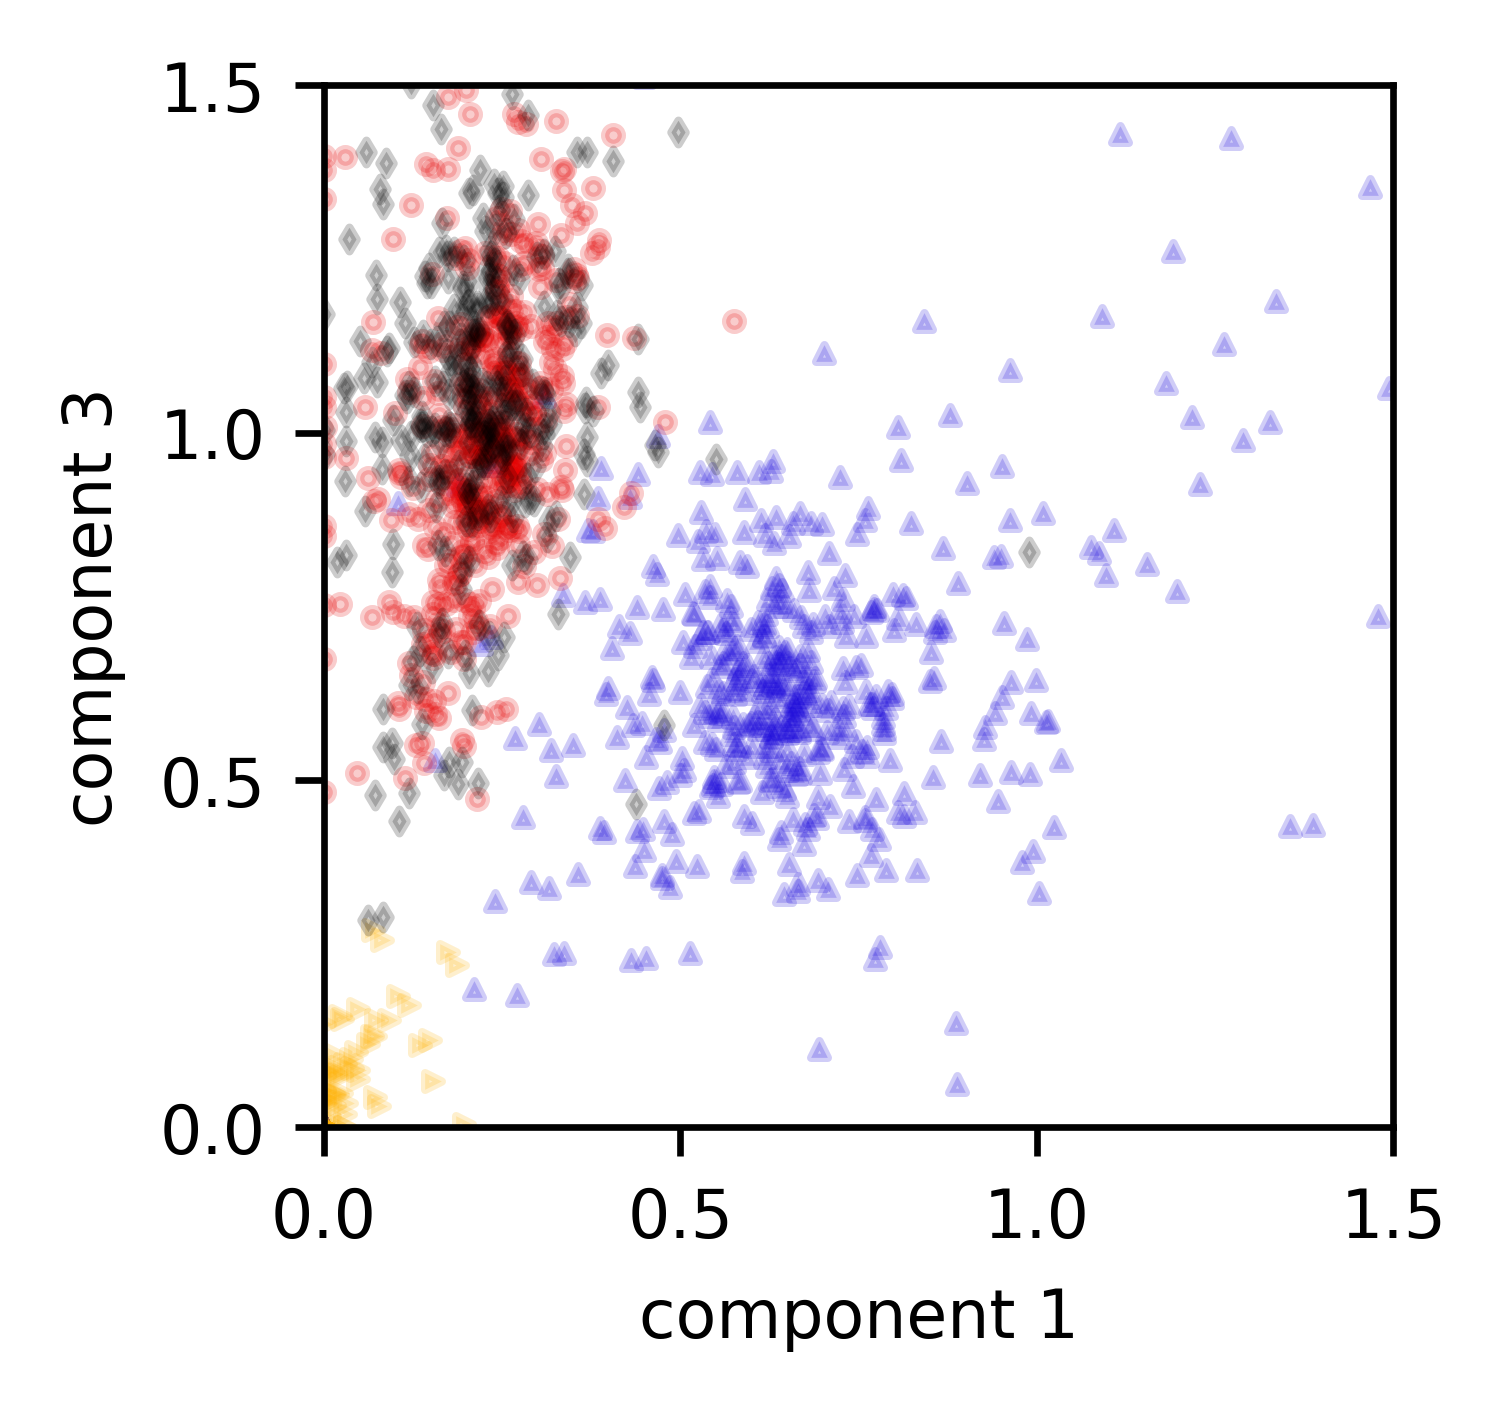

In [36]:
plt.figure(figsize=(2.3,2.3), dpi=600)

colors = ['ultramarine blue', 'amber', 'red', 'black']  ##H750, H600, H415, H020
pal = sns.xkcd_palette(colors) 

com_x = 0
com_y = 2

plt.scatter(W7[::1000,com_x], W7[::1000,com_y], s = 4, c = pal[0], marker = '^', alpha = 0.2)# edgecolors = None)
plt.scatter(W6[::1000,com_x], W6[::1000,com_y], s = 4, c = pal[1], marker = '>', alpha = 0.2)# edgecolors = None)
plt.scatter(W4[::1000,com_x], W4[::1000,com_y], s = 4, c = pal[2], marker = 'o', alpha = 0.2)# edgecolors = None)
plt.scatter(W2[::1000,com_x], W2[::1000,com_y], s = 4, c = pal[3], marker = 'd', alpha = 0.2)# edgecolors = None)

#plt.scatter(W7L[:,0], W7L[:,2], s = 0.05, c = 'green', marker = '.', alpha = 0.05)
#plt.scatter(W2L[:,0], W2L[:,2], s = 0.05, c = 'cyan', marker = '.', alpha = 0.05)


plt.xlabel('component %s' %(com_x +1))
plt.ylabel('component %s' %(com_y +1))
plt.xlim(0,1.5)  
plt.ylim(0,1.5)
xticks(np.arange(0,1.5001, step=0.5))
yticks(np.arange(0,1.5001, step=0.5))


##saving componentvscomponent as a png
savefmt = os.path.join('dataset_27',
                       '{}{}{}{}{}{{:d}}.png'.format('NMF_H750fit_com_of_', Nn, '_', date, '_'))
i = 0
while os.path.exists(savefmt.format(i)):
    i += 1
plt.savefig(savefmt.format(i), bbox_inches = 'tight')

Extra, with the oil samples

In [37]:
##with oil samples too
df_all = pd.concat([df_W7.iloc[::5000,:],
                    df_W6.iloc[::5000,:],
                    df_W4.iloc[::5000,:],
                    df_W2.iloc[::5000,:],
                    df_W7L.iloc[::5000,:],
                    df_W2L.iloc[::5000,:]], axis =0)
df_all.cat = df_all.cat.astype('category')
df_all.dtypes

W1      float64
W2      float64
W3      float64
cat    category
dtype: object

In [38]:
colors = ['ultramarine blue', 'amber', 'red', 'black', 'magenta', 'green']
##H750, H600, H415, H020, H750oilL4, H020oilL4

pal = sns.xkcd_palette(colors) 

<Figure size 15600x15600 with 0 Axes>

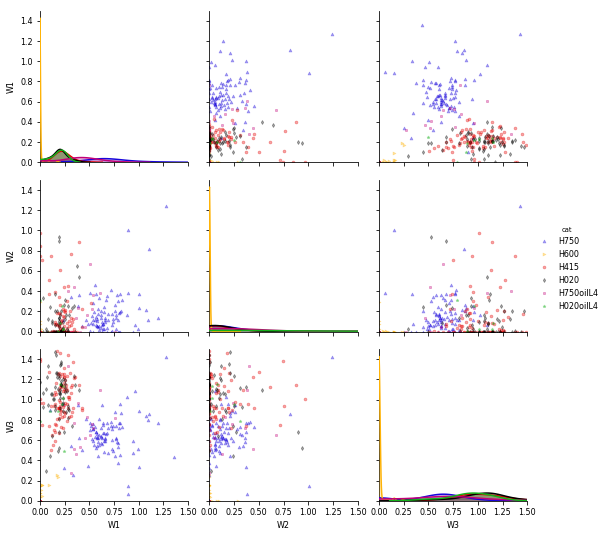

In [39]:
##complete pairplot of all components, all samples

plt.figure(figsize=(26,26), dpi=600)
g = sns.pairplot(df_all, hue = "cat", hue_order = ['H750', 'H600', 'H415', 'H020', 'H750oilL4', 'H020oilL4'], palette = pal, markers = ["^", ">", "o", "d", "s", "*"], diag_kind = "kde", plot_kws=dict(s = 8, edgecolor = None, alpha = 0.35))

g.set(xlim=(0,1.5))
g.set(ylim=(0,1.5))

##saving componentvscomponent as a png
savefmt = os.path.join('dataset_27',
                       '{}{}{}{}{}{{:d}}.png'.format('NMFhist_H750fit_com_of_', Nn, '_', date, '_'))
i = 0
while os.path.exists(savefmt.format(i)):
    i += 1
plt.savefig(savefmt.format(i), bbox_inches = 'tight')

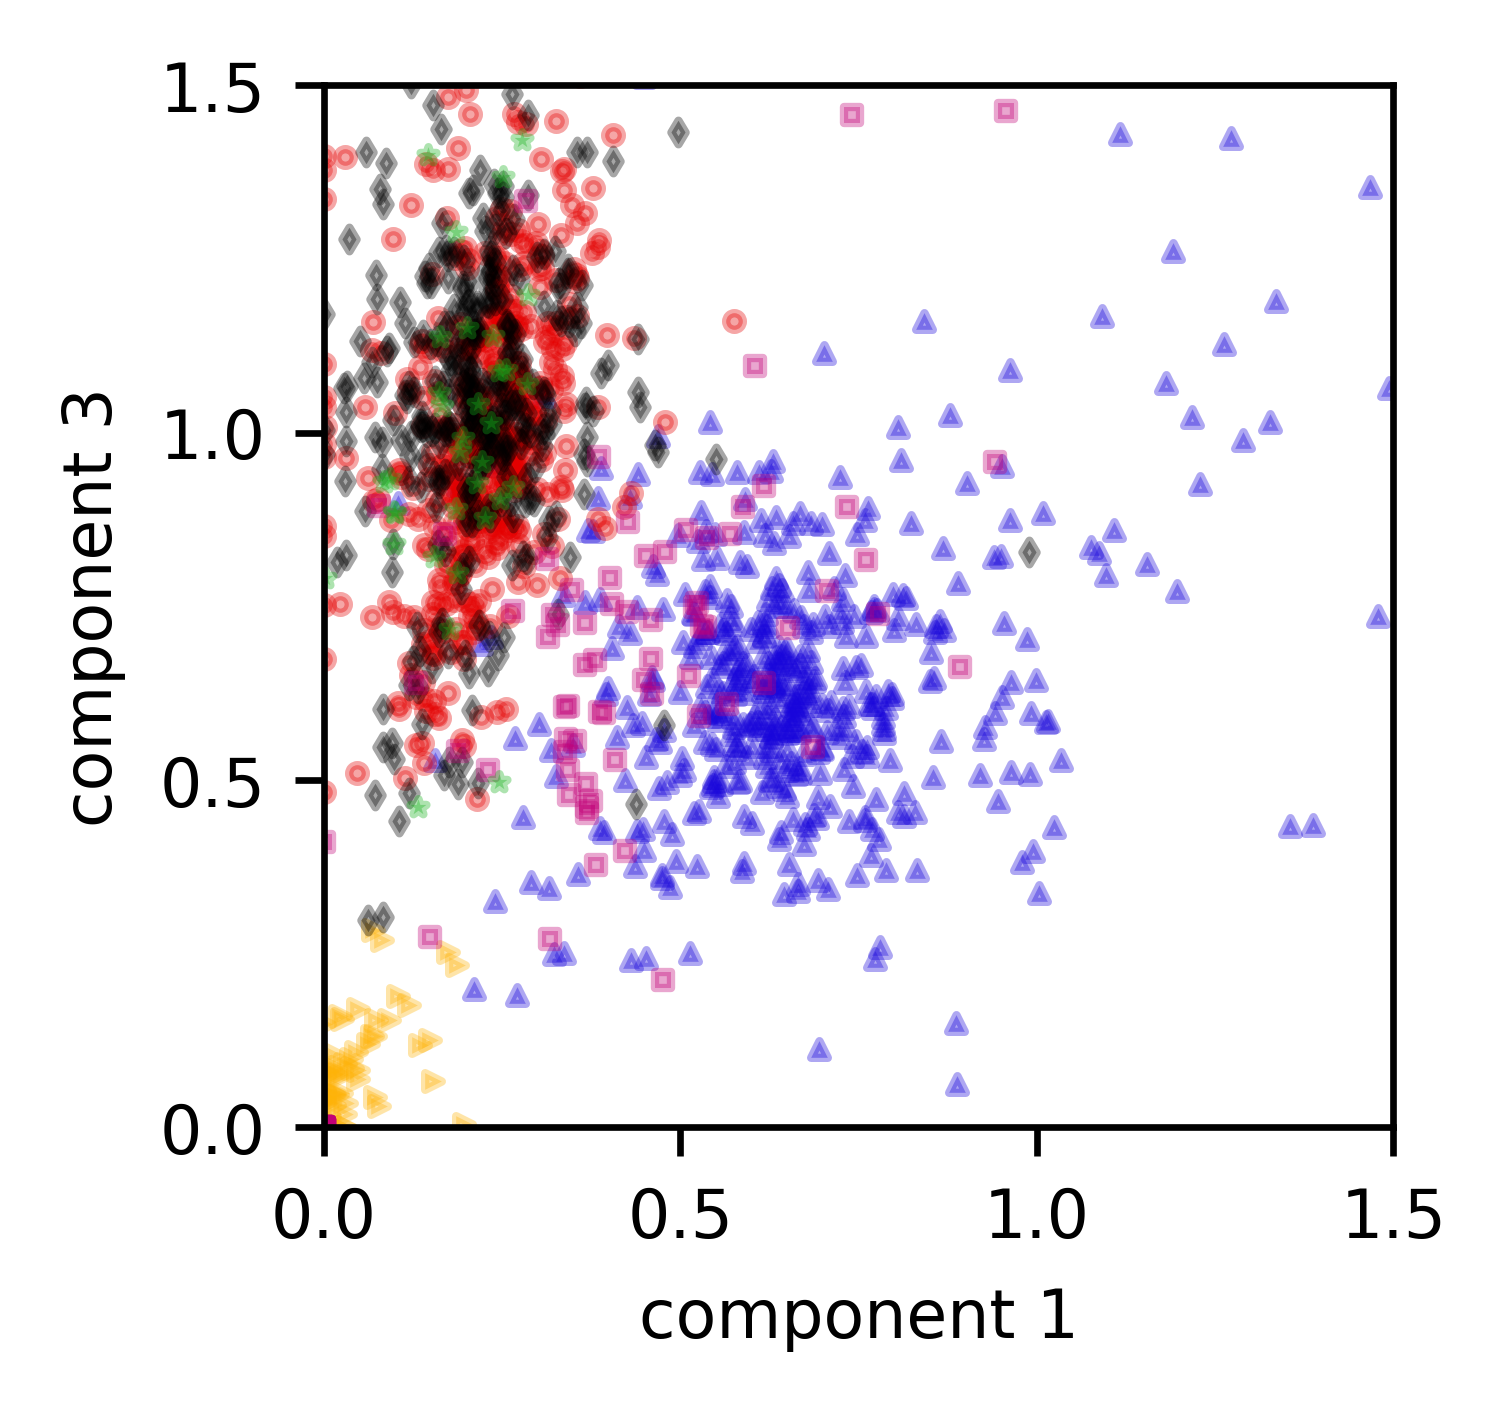

In [40]:
plt.figure(figsize=(2.3,2.3), dpi=600)

colors = ['ultramarine blue', 'amber', 'red', 'black', 'magenta', 'green']
##H750, H600, H415, H020, H750oilL4, H020oilL4
pal = sns.xkcd_palette(colors) 

com_x = 0
com_y = 2

plt.scatter(W7[::1000,com_x], W7[::1000,com_y], s = 4, c = pal[0], marker = '^', alpha = 0.35)# edgecolors = None)
plt.scatter(W6[::1000,com_x], W6[::1000,com_y], s = 4, c = pal[1], marker = '>', alpha = 0.35)# edgecolors = None)
plt.scatter(W4[::1000,com_x], W4[::1000,com_y], s = 4, c = pal[2], marker = 'o', alpha = 0.35)# edgecolors = None)
plt.scatter(W2[::1000,com_x], W2[::1000,com_y], s = 4, c = pal[3], marker = 'd', alpha = 0.35)# edgecolors = None)
plt.scatter(W7L[::1000,com_x], W7L[::1000,com_y], s = 4, c = pal[4], marker = 's', alpha = 0.35)# edgecolors = None)
plt.scatter(W2L[::1000,com_x], W2L[::1000,com_y], s = 4, c = pal[5], marker = '*', alpha = 0.35)# edgecolors = None)

plt.xlabel('component %s' %(com_x +1))
plt.ylabel('component %s' %(com_y +1))
plt.xlim(0,1.5)  
plt.ylim(0,1.5)
xticks(np.arange(0,1.5001, step=0.5))
yticks(np.arange(0,1.5001, step=0.5))


##saving componentvscomponent as a png
savefmt = os.path.join('dataset_27',
                       '{}{}{}{}{}{{:d}}.png'.format('NMFoil_H750fit_com_of_', Nn, '_', date, '_'))
i = 0
while os.path.exists(savefmt.format(i)):
    i += 1
plt.savefig(savefmt.format(i), bbox_inches = 'tight')

## Treatment Vc:

Change directory to where you want to save NMF images

In [41]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In the next cell, select the component for plotting and then run all the cells that follow until the end. Repeat this for all components.

In [42]:
##selecting two components and plot difference
com_na = 0
com_nb = 2

##selects the chosen component from the array of components for each sample
W7_com_a = W7[:,com_na]
W7_com_b = W7[:,com_nb]

W6_com_a = W6[:,com_na]
W6_com_b = W6[:,com_nb]

W4_com_a = W4[:,com_na]
W4_com_b = W4[:,com_nb]

W2_com_a = W2[:,com_na]
W2_com_b = W2[:,com_nb]

W7L_com_a = W7L[:,com_na]
W7L_com_b = W7L[:,com_nb]

W2L_com_a = W2L[:,com_na]
W2L_com_b = W2L[:,com_nb]

W7_com = W7_com_b - W7_com_a
W6_com = W6_com_b - W6_com_a
W4_com = W4_com_b - W4_com_a
W2_com = W2_com_b - W2_com_a
W7L_com = W7L_com_b - W7L_com_a
W2L_com = W2L_com_b - W2L_com_a

-0.015644259345376336
0.24388424551242913
0.716008477191911
-0.7472969958826637


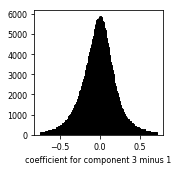

In [43]:
##histogram of coefficients for the chosen component for H-750

plt.figure(figsize=(2.3,2.3))

W7_com_mn = W7_com.mean(axis=0)
print(W7_com_mn)
W7_com_st = W7_com.std(axis=0)
print(W7_com_st)

##range for plot
chi_7 = W7_com_mn + 3*W7_com_st    ## mean plus 3 std
clo_7 = W7_com_mn - 3*W7_com_st    ## mean minus 3 std                         
print(chi_7)
print(clo_7)

plt.hist(W7_com[W7_com!=0], bins=256, range=(clo_7,chi_7), fc='k', ec='k') 
plt.xlabel('coefficient for component {} minus {}'.format(com_nb+1, com_na+1))

##saving histogram as a pdf
savefmt = os.path.join('dataset_28',
                       '{}{}{}{}{}{}{}{}{}{}{{:d}}.pdf'.format('hist_', basename_7, '_diff', com_nb+1, com_na+1, '_of_', Nn, '_', date, '_'))
i = 0
while os.path.exists(savefmt.format(i)):
    i += 1
plt.savefig(savefmt, bbox_inches = 'tight')

0.0023747324091648514
0.019629031000158347
0.06126182540963989
-0.056512360591310186


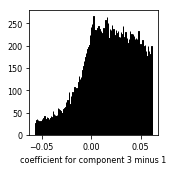

In [44]:
##histogram of coefficients for the chosen component for H-600
plt.figure(figsize=(2.3,2.3))

W6_com_mn = W6_com.mean(axis=0)
print(W6_com_mn)
W6_com_st = W6_com.std(axis=0)
print(W6_com_st)


##range for plot
chi_6 = W6_com_mn + 3*W6_com_st    ## mean plus 3 std
clo_6 = W6_com_mn - 3*W6_com_st    ## mean minus 3 std
print(chi_6)
print(clo_6)

plt.hist(W6_com[W6_com!=0], bins=256, range=(clo_6,chi_6), fc='k', ec='k')
plt.xlabel('coefficient for component {} minus {}'.format(com_nb+1, com_na+1))

##saving histogram as a pdf
savefmt = os.path.join('dataset_28',
                       '{}{}{}{}{}{}{}{}{}{}{{:d}}.pdf'.format('hist_', basename_6, '_diff', com_nb+1, com_na+1, '_of_', Nn, '_', date, '_'))
i = 0
while os.path.exists(savefmt.format(i)):
    i += 1
plt.savefig(savefmt.format(i), bbox_inches = 'tight')

0.8010978254664566
0.21814424806926036
1.4555305696742376
0.1466650812586755


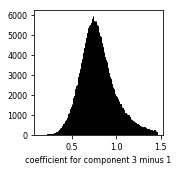

In [45]:
##histogram of coefficients for the chosen component for H-415
plt.figure(figsize=(2.3,2.3))

W4_com_mn = W4_com.mean(axis=0)
print(W4_com_mn)
W4_com_st = W4_com.std(axis=0)
print(W4_com_st)

##range for plot
chi_4 = W4_com_mn + 3*W4_com_st    ## mean plus 3 std
clo_4 = W4_com_mn - 3*W4_com_st    ## mean minus 3 std
print(chi_4)
print(clo_4)

plt.hist(W4_com[W4_com!=0], bins=256, range=(clo_4,chi_4), fc='k', ec='k') 
plt.xlabel('coefficient for component {} minus {}'.format(com_nb+1, com_na+1))

##saving histogram as a pdf
savefmt = os.path.join('dataset_28',
                       '{}{}{}{}{}{}{}{}{}{}{{:d}}.pdf'.format('hist_', basename_4, '_diff', com_nb+1, com_na+1, '_of_', Nn, '_', date, '_'))
i = 0
while os.path.exists(savefmt.format(i)):
    i += 1
plt.savefig(savefmt.format(i), bbox_inches = 'tight')

0.8261459278640918
0.207633212055373
1.449045564030211
0.20324629169797281


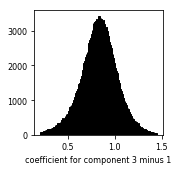

In [46]:
##histogram of coefficients for the chosen component for H-020
plt.figure(figsize=(2.3,2.3))

W2_com_mn = W2_com.mean(axis=0)
print(W2_com_mn)
W2_com_st = W2_com.std(axis=0)
print(W2_com_st)

##range for plot
chi_2 = W2_com_mn + 3*W2_com_st    ## mean plus 3 std
clo_2 = W2_com_mn - 3*W2_com_st    ## mean minus 3 std
print(chi_2)
print(clo_2)

plt.hist(W2_com[W2_com!=0], bins=256, range=(clo_2,chi_2), fc='k', ec='k')
plt.xlabel('coefficient for component {} minus {}'.format(com_nb+1, com_na+1))

##saving histogram as a pdf
savefmt = os.path.join('dataset_28',
                       '{}{}{}{}{}{}{}{}{}{}{{:d}}.pdf'.format('hist_', basename_2, '_diff', com_nb+1, com_na+1, '_of_', Nn, '_', date, '_'))
i = 0
while os.path.exists(savefmt.format(i)):
    i += 1
plt.savefig(savefmt.format(i), bbox_inches = 'tight')

0.23377519271341618
0.24830123361619472
0.9786788935620003
-0.511128508135168


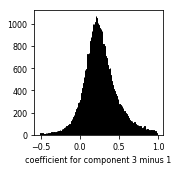

In [47]:
##histogram of coefficients for the chosen component for H-750oilL4
plt.figure(figsize=(2.3,2.3))

W7L_com_mn = W7L_com.mean(axis=0)
print(W7L_com_mn)
W7L_com_st = W7L_com.std(axis=0)
print(W7L_com_st)

##range for plot
chi_7L = W7L_com_mn + 3*W7L_com_st    ## mean plus 3 std
clo_7L = W7L_com_mn - 3*W7L_com_st    ## mean minus 3 std
print(chi_7L)
print(clo_7L)

plt.hist(W7L_com[W7L_com!=0], bins=256, range=(clo_7L,chi_7L), fc='k', ec='k')
plt.xlabel('coefficient for component {} minus {}'.format(com_nb+1, com_na+1))

##saving histogram as a pdf
savefmt = os.path.join('dataset_28',
                       '{}{}{}{}{}{}{}{}{}{}{{:d}}.pdf'.format('hist_', basename_7L, '_diff', com_nb+1, com_na+1, '_of_', Nn, '_', date, '_'))
i = 0
while os.path.exists(savefmt.format(i)):
    i += 1
plt.savefig(savefmt.format(i), bbox_inches = 'tight')

0.8003937854577993
0.29608336742633423
1.688643887736802
-0.08785631682120343


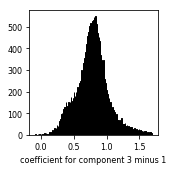

In [48]:
##histogram of coefficients for the chosen component for H-020oilL4
plt.figure(figsize=(2.3,2.3))

W2L_com_mn = W2L_com.mean(axis=0)
print(W2L_com_mn)
W2L_com_st = W2L_com.std(axis=0)
print(W2L_com_st)

##range for plot
chi_2L = W2L_com_mn + 3*W2L_com_st    ## mean plus 3 std
clo_2L = W2L_com_mn - 3*W2L_com_st    ## mean minus 3 std
print(chi_2L)
print(clo_2L)

plt.hist(W2L_com[W2L_com!=0], bins=256, range=(clo_2L,chi_2L), fc='k', ec='k')
plt.xlabel('coefficient for component {} minus {}'.format(com_nb+1, com_na+1))

##saving histogram as a pdf
savefmt = os.path.join('dataset_28',
                       '{}{}{}{}{}{}{}{}{}{}{{:d}}.pdf'.format('hist_', basename_2L, '_diff', com_nb+1, com_na+1, '_of_', Nn, '_', date, '_'))
i = 0
while os.path.exists(savefmt.format(i)):
    i += 1
plt.savefig(savefmt.format(i), bbox_inches = 'tight')

In [49]:
##changing from pixel x pixel to micrometers x micrometers as determined by objective used at the beamline ID21 (ESRF)

print(mn_7.shape) ## in pixels
V_um_7 = mn_7.shape[0] * 0.7 ##vertical, height
H_um_7 = mn_7.shape[1] * 0.7 ##horizontal, width
print(V_um_7, H_um_7) ## corrected to be in microns

print(mn_6.shape) ## in pixels
V_um_6 = mn_6.shape[0] * 0.7 ##vertical, height
H_um_6 = mn_6.shape[1] * 0.7 ##horizontal, width
print(V_um_6, H_um_6) ## corrected to be in microns

print(mn_4.shape) ## in pixels
V_um_4 = mn_4.shape[0] * 0.7 ##vertical, height
H_um_4 = mn_4.shape[1] * 0.7 ##horizontal, width
print(V_um_4, H_um_4) ## corrected to be in microns

print(mn_2.shape) ## in pixels
V_um_2 = mn_2.shape[0] * 0.7 ##vertical, height
H_um_2 = mn_2.shape[1] * 0.7 ##horizontal, width
print(V_um_2, H_um_2) ## corrected to be in microns

print(mn_7L.shape) ## in pixels
V_um_7L = mn_7L.shape[0] * 0.7 ##vertical, height
H_um_7L = mn_7L.shape[1] * 0.7 ##horizontal, width
print(V_um_7L, H_um_7L) ## corrected to be in microns

print(mn_2L.shape) ## in pixels
V_um_2L = mn_2L.shape[0] * 0.7 ##vertical, height
H_um_2L = mn_2L.shape[1] * 0.7 ##horizontal, width
print(V_um_2L, H_um_2L) ## corrected to be in microns

(1520, 2020)
1064.0 1414.0
(2148, 1796)
1503.6 1257.1999999999998
(2179, 1720)
1525.3 1204.0
(1720, 1670)
1204.0 1169.0
(1420, 1720)
993.9999999999999 1204.0
(1520, 1520)
1064.0 1064.0


In [50]:
##preparing colormap
color_choice = plt.cm.viridis
back_color = 'white'

##note: range for all images based on H-750 histogram average and standard deviation (ie, clo_7 and chi_7)

In [51]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [52]:
W7_com_mn = W7_com.mean(axis=0)
print(W7_com_mn)
W7_com_st = W7_com.std(axis=0)
print(W7_com_st)

W6_com_mn = W6_com.mean(axis=0)
print(W6_com_mn)
W6_com_st = W6_com.std(axis=0)
print(W6_com_st)

W4_com_mn = W4_com.mean(axis=0)
print(W4_com_mn)
W4_com_st = W4_com.std(axis=0)
print(W4_com_st)

W2_com_mn = W2_com.mean(axis=0)
print(W2_com_mn)
W2_com_st = W2_com.std(axis=0)
print(W2_com_st)


W7L_com_mn = W7L_com.mean(axis=0)
print(W7L_com_mn)
W7L_com_st = W7L_com.std(axis=0)
print(W7L_com_st)

W2L_com_mn = W2L_com.mean(axis=0)
print(W2L_com_mn)
W2L_com_st = W2L_com.std(axis=0)
print(W2L_com_st)

-0.015644259345376336
0.24388424551242913
0.0023747324091648514
0.019629031000158347
0.8010978254664566
0.21814424806926036
0.8261459278640918
0.207633212055373
0.23377519271341618
0.24830123361619472
0.8003937854577993
0.29608336742633423


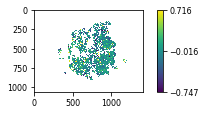

In [53]:
fig, ax = plt.subplots(figsize=(2.3,2.3))

image_7 = zeros(wanted_7.shape, dtype=W7.dtype)
image_7[wanted_7!=False] = W7_com

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
cmap = color_choice

image_7[wanted_7==False] = 0
image_7 = np.ma.masked_equal(image_7, 0)
cmap.set_bad(color=back_color)

want_im_7 = ax.imshow(image_7, cmap=cmap, interpolation='none', extent=[0, H_um_7, V_um_7, 0], clim = (clo_7,chi_7))
cbar = fig.colorbar(want_im_7, cax=cax, ticks=[clo_7, (chi_7+clo_7)/2, chi_7], orientation='vertical')

##saving image as a pdf and svg
savefmt = os.path.join('dataset_28',
                       '{}{}{}{}{}{}{}{}{}{{:d}}.{{}}'.format(basename_7, '_diff', com_nb+1, com_na+1, '_of_', Nn, '_', date, '_'))
i = 0
while os.path.exists(savefmt.format(i, 'pdf')):
    i += 1
plt.savefig(savefmt.format(i, 'pdf'), bbox_inches = 'tight')
plt.savefig(savefmt.format(i, 'svg'), bbox_inches = 'tight')

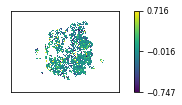

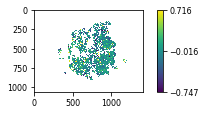

In [54]:
fig, ax = plt.subplots(figsize=(2.3,2.3))

image_7 = zeros(wanted_7.shape, dtype=W7.dtype)
image_7[wanted_7!=False] = W7_com

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
cmap = color_choice

image_7[wanted_7==False] = 0
image_7 = np.ma.masked_equal(image_7, 0)
cmap.set_bad(color=back_color)

want_im_7 = ax.imshow(image_7, cmap=cmap, interpolation='none', extent=[0, H_um_7, V_um_7, 0], clim = (clo_7,chi_7))
cbar = fig.colorbar(want_im_7, cax=cax, ticks=[clo_7, (chi_7+clo_7)/2, chi_7], orientation='vertical')

want_im_7.axes.get_xaxis().set_ticks([])
want_im_7.axes.get_yaxis().set_ticks([])

##saving image as a pdf and svg
fig, ax = plt.subplots(figsize=(2.3,2.3))

image_7 = zeros(wanted_7.shape, dtype=W7.dtype)
image_7[wanted_7!=False] = W7_com

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
cmap = color_choice

image_7[wanted_7==False] = 0
image_7 = np.ma.masked_equal(image_7, 0)
cmap.set_bad(color=back_color)

want_im_7 = ax.imshow(image_7, cmap=cmap, interpolation='none', extent=[0, H_um_7, V_um_7, 0], clim = (clo_7,chi_7))
cbar = fig.colorbar(want_im_7, cax=cax, ticks=[clo_7, (chi_7+clo_7)/2, chi_7], orientation='vertical')

##saving image as a pdf and svg
savefmt = os.path.join('dataset_28',
                       '{}{}{}{}{}{}{}{}{}{{:d}}.{{}}'.format(basename_7, 'notix_diff', com_nb+1, com_na+1, '_of_', Nn, '_', date, '_'))
i = 0
while os.path.exists(savefmt.format(i, 'pdf')):
    i += 1
plt.savefig(savefmt.format(i, 'pdf'), bbox_inches = 'tight')
plt.savefig(savefmt.format(i, 'svg'), bbox_inches = 'tight')

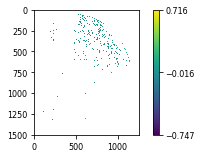

In [55]:
fig, ax = plt.subplots(figsize=(2.3,2.3))

image_6 = zeros(wanted_6.shape, dtype=W6.dtype)
image_6[wanted_6!=False] = W6_com

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
cmap = color_choice

image_6[wanted_6==False] = 0
image_6 = np.ma.masked_equal(image_6, 0)
cmap.set_bad(color=back_color)

want_im_6 = ax.imshow(image_6, cmap=cmap, interpolation='none', extent=[0, H_um_6, V_um_6, 0], clim = (clo_7,chi_7))
cbar = fig.colorbar(want_im_6, cax=cax, ticks=[clo_7, (chi_7+clo_7)/2, chi_7], orientation='vertical')

##saving image as a pdf and svg
savefmt = os.path.join('dataset_28',
                       '{}{}{}{}{}{}{}{}{}{{:d}}.{{}}'.format(basename_6, '_diff', com_nb+1, com_na+1, '_of_', Nn, '_', date, '_'))
i = 0
while os.path.exists(savefmt.format(i, 'pdf')):
    i += 1
plt.savefig(savefmt.format(i, 'pdf'), bbox_inches = 'tight')
plt.savefig(savefmt.format(i, 'svg'), bbox_inches = 'tight')

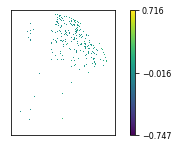

In [56]:
fig, ax = plt.subplots(figsize=(2.3,2.3))

image_6 = zeros(wanted_6.shape, dtype=W6.dtype)
image_6[wanted_6!=False] = W6_com

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
cmap = color_choice

image_6[wanted_6==False] = 0
image_6 = np.ma.masked_equal(image_6, 0)
cmap.set_bad(color=back_color)

want_im_6 = ax.imshow(image_6, cmap=cmap, interpolation='none', extent=[0, H_um_6, V_um_6, 0], clim = (clo_7,chi_7))
cbar = fig.colorbar(want_im_6, cax=cax, ticks=[clo_7, (chi_7+clo_7)/2, chi_7], orientation='vertical')

want_im_6.axes.get_xaxis().set_ticks([])
want_im_6.axes.get_yaxis().set_ticks([])

##saving image as a pdf and svg
savefmt = os.path.join('dataset_28',
                       '{}{}{}{}{}{}{}{}{}{{:d}}.{{}}'.format(basename_6, 'notix_diff', com_nb+1, com_na+1, '_of_', Nn, '_', date, '_'))
i = 0
while os.path.exists(savefmt.format(i, 'pdf')):
    i += 1
plt.savefig(savefmt.format(i, 'pdf'), bbox_inches = 'tight')
plt.savefig(savefmt.format(i, 'svg'), bbox_inches = 'tight')

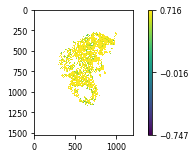

In [57]:
fig, ax = plt.subplots(figsize=(2.3,2.3))

image_4 = zeros(wanted_4.shape, dtype=W4.dtype)
image_4[wanted_4!=False] = W4_com

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
cmap = color_choice

image_4[wanted_4==False] = 0
image_4 = np.ma.masked_equal(image_4, 0)
cmap.set_bad(color=back_color)

want_im_4 = ax.imshow(image_4, cmap=cmap, interpolation='none', extent=[0, H_um_4, V_um_4, 0], clim = (clo_7,chi_7))
cbar = fig.colorbar(want_im_4, cax=cax, ticks=[clo_7, (chi_7+clo_7)/2, chi_7], orientation='vertical')

##saving image as a pdf and svg
savefmt = os.path.join('dataset_28',
                       '{}{}{}{}{}{}{}{}{}{{:d}}.{{}}'.format(basename_4, 'diff', com_nb+1, com_na+1, '_of_', Nn, '_', date, '_'))
i = 0
while os.path.exists(savefmt.format(i, 'pdf')):
    i += 1
plt.savefig(savefmt.format(i, 'pdf'), bbox_inches = 'tight')
plt.savefig(savefmt.format(i, 'svg'), bbox_inches = 'tight')

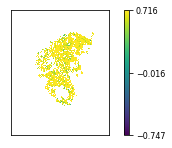

In [58]:
fig, ax = plt.subplots(figsize=(2.3,2.3))

image_4 = zeros(wanted_4.shape, dtype=W4.dtype)
image_4[wanted_4!=False] = W4_com

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
cmap = color_choice

image_4[wanted_4==False] = 0
image_4 = np.ma.masked_equal(image_4, 0)
cmap.set_bad(color=back_color)

want_im_4 = ax.imshow(image_4, cmap=cmap, interpolation='none', extent=[0, H_um_4, V_um_4, 0], clim = (clo_7,chi_7))
cbar = fig.colorbar(want_im_4, cax=cax, ticks=[clo_7, (chi_7+clo_7)/2, chi_7], orientation='vertical')

want_im_4.axes.get_xaxis().set_ticks([])
want_im_4.axes.get_yaxis().set_ticks([])

##saving image as a pdf and svg
savefmt = os.path.join('dataset_28',
                       '{}{}{}{}{}{}{}{}{}{{:d}}.{{}}'.format(basename_4, 'notix_diff', com_nb+1, com_na+1, '_of_', Nn, '_', date, '_'))
i = 0
while os.path.exists(savefmt.format(i, 'pdf')):
    i += 1
plt.savefig(savefmt.format(i, 'pdf'), bbox_inches = 'tight')
plt.savefig(savefmt.format(i, 'svg'), bbox_inches = 'tight')

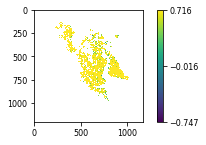

In [59]:
fig, ax = plt.subplots(figsize=(2.3,2.3))

image_2 = zeros(wanted_2.shape, dtype=W2.dtype)
image_2[wanted_2!=False] = W2_com


divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
cmap = color_choice

image_2[wanted_2==False] = 0
image_2 = np.ma.masked_equal(image_2, 0)
cmap.set_bad(color=back_color)

want_im_2 = ax.imshow(image_2, cmap=cmap, interpolation='none', extent=[0, H_um_2, V_um_2, 0], clim = (clo_7,chi_7))
cbar = fig.colorbar(want_im_2, cax=cax, ticks=[clo_7, (chi_7+clo_7)/2, chi_7], orientation='vertical')

##saving image as a pdf and svg
savefmt = os.path.join('dataset_28',
                       '{}{}{}{}{}{}{}{}{}{{:d}}.{{}}'.format(basename_2, 'diff', com_nb+1, com_na+1, '_of_', Nn, '_', date, '_'))
i = 0
while os.path.exists(savefmt.format(i, 'pdf')):
    i += 1
plt.savefig(savefmt.format(i, 'pdf'), bbox_inches = 'tight')
plt.savefig(savefmt.format(i, 'svg'), bbox_inches = 'tight')

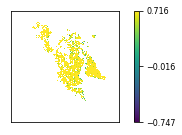

In [60]:
fig, ax = plt.subplots(figsize=(2.3,2.3))

image_2 = zeros(wanted_2.shape, dtype=W2.dtype)
image_2[wanted_2!=False] = W2_com


divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
cmap = color_choice

image_2[wanted_2==False] = 0
image_2 = np.ma.masked_equal(image_2, 0)
cmap.set_bad(color=back_color)

want_im_2 = ax.imshow(image_2, cmap=cmap, interpolation='none', extent=[0, H_um_2, V_um_2, 0], clim = (clo_7,chi_7))
cbar = fig.colorbar(want_im_2, cax=cax, ticks=[clo_7, (chi_7+clo_7)/2, chi_7], orientation='vertical')

want_im_2.axes.get_xaxis().set_ticks([])
want_im_2.axes.get_yaxis().set_ticks([])

##saving image as a pdf and svg
savefmt = os.path.join('dataset_28',
                       '{}{}{}{}{}{}{}{}{}{{:d}}.{{}}'.format(basename_2, 'notix_diff', com_nb+1, com_na+1, '_of_', Nn, '_', date, '_'))
i = 0
while os.path.exists(savefmt.format(i, 'pdf')):
    i += 1
plt.savefig(savefmt.format(i, 'pdf'), bbox_inches = 'tight')
plt.savefig(savefmt.format(i, 'svg'), bbox_inches = 'tight')

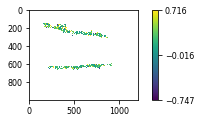

In [61]:
fig, ax = plt.subplots(figsize=(2.3,2.3))

image_7L = zeros(wanted_7L.shape, dtype=W7L.dtype)
image_7L[wanted_7L!=False] = W7L_com

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
cmap = color_choice

image_7L[wanted_7L==False] = 0
image_7L = np.ma.masked_equal(image_7L, 0)
cmap.set_bad(color=back_color)

want_im_7L = ax.imshow(image_7L, cmap=cmap, interpolation='none', extent=[0, H_um_7L, V_um_7L, 0], clim = (clo_7,chi_7))
cbar = fig.colorbar(want_im_7L, cax=cax, ticks=[clo_7, (chi_7+clo_7)/2, chi_7], orientation='vertical')

##saving image as a pdf and svg
savefmt = os.path.join('dataset_28',
                       '{}{}{}{}{}{}{}{}{}{{:d}}.{{}}'.format(basename_7L, 'diff', com_nb+1, com_na+1, '_of_', Nn, '_', date, '_'))
i = 0
while os.path.exists(savefmt.format(i, 'pdf')):
    i += 1
plt.savefig(savefmt.format(i, 'pdf'), bbox_inches = 'tight')
plt.savefig(savefmt.format(i, 'svg'), bbox_inches = 'tight')

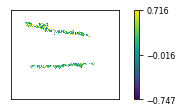

In [62]:
fig, ax = plt.subplots(figsize=(2.3,2.3))

image_7L = zeros(wanted_7L.shape, dtype=W7L.dtype)
image_7L[wanted_7L!=False] = W7L_com

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
cmap = color_choice

image_7L[wanted_7L==False] = 0
image_7L = np.ma.masked_equal(image_7L, 0)
cmap.set_bad(color=back_color)

want_im_7L = ax.imshow(image_7L, cmap=cmap, interpolation='none', extent=[0, H_um_7L, V_um_7L, 0], clim = (clo_7,chi_7))
cbar = fig.colorbar(want_im_7L, cax=cax, ticks=[clo_7, (chi_7+clo_7)/2, chi_7], orientation='vertical')

want_im_7L.axes.get_xaxis().set_ticks([])
want_im_7L.axes.get_yaxis().set_ticks([])

##saving image as a pdf and svg
savefmt = os.path.join('dataset_28',
                       '{}{}{}{}{}{}{}{}{}{{:d}}.{{}}'.format(basename_7L, 'notix_diff', com_nb+1, com_na+1, '_of_', Nn, '_', date, '_'))
i = 0
while os.path.exists(savefmt.format(i, 'pdf')):
    i += 1
plt.savefig(savefmt.format(i, 'pdf'), bbox_inches = 'tight')
plt.savefig(savefmt.format(i, 'svg'), bbox_inches = 'tight')

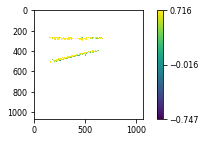

In [63]:
fig, ax = plt.subplots(figsize=(2.3,2.3))

image_2L = zeros(wanted_2L.shape, dtype=W2L.dtype)
image_2L[wanted_2L!=False] = W2L_com


divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
cmap = color_choice

image_2L[wanted_2L==False] = 0
image_2L = np.ma.masked_equal(image_2L, 0)
cmap.set_bad(color=back_color)

want_im_2L = ax.imshow(image_2L, cmap=cmap, interpolation='none', extent=[0, H_um_2L, V_um_2L, 0], clim = (clo_7,chi_7))
cbar = fig.colorbar(want_im_2L, cax=cax, ticks=[clo_7, (chi_7+clo_7)/2, chi_7], orientation='vertical')

##saving image as a pdf and svg
savefmt = os.path.join('dataset_28',
                       '{}{}{}{}{}{}{}{}{}{{:d}}.{{}}'.format(basename_2L, 'diff', com_nb+1, com_na+1, '_of_', Nn, '_', date, '_'))
i = 0
while os.path.exists(savefmt.format(i, 'pdf')):
    i += 1
plt.savefig(savefmt.format(i, 'pdf'), bbox_inches = 'tight')
plt.savefig(savefmt.format(i, 'svg'), bbox_inches = 'tight')

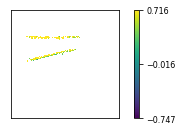

In [64]:
fig, ax = plt.subplots(figsize=(2.3,2.3))

image_2L = zeros(wanted_2L.shape, dtype=W2L.dtype)
image_2L[wanted_2L!=False] = W2L_com


divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
cmap = color_choice

image_2L[wanted_2L==False] = 0
image_2L = np.ma.masked_equal(image_2L, 0)
cmap.set_bad(color=back_color)

want_im_2L = ax.imshow(image_2L, cmap=cmap, interpolation='none', extent=[0, H_um_2L, V_um_2L, 0], clim = (clo_7,chi_7))
cbar = fig.colorbar(want_im_2L, cax=cax, ticks=[clo_7, (chi_7+clo_7)/2, chi_7], orientation='vertical')

want_im_2L.axes.get_xaxis().set_ticks([])
want_im_2L.axes.get_yaxis().set_ticks([])

##saving image as a pdf and svg
savefmt = os.path.join('dataset_28',
                       '{}{}{}{}{}{}{}{}{}{{:d}}.{{}}'.format(basename_2L, 'notix_diff', com_nb+1, com_na+1, '_of_', Nn, '_', date, '_'))
i = 0
while os.path.exists(savefmt.format(i, 'pdf')):
    i += 1
plt.savefig(savefmt.format(i, 'pdf'), bbox_inches = 'tight')
plt.savefig(savefmt.format(i, 'svg'), bbox_inches = 'tight')

In [65]:
##below, for plotting single components

In [66]:
##select a component for plotting
#com_n = 0
#com_n = 1
com_n = 2

##selects the chosen component from the array of components for each sample
W7_com = W7[:,com_n]
print(W7_com.shape)

W6_com = W6[:,com_n]
print(W6_com.shape)

W4_com = W4[:,com_n]
print(W4_com.shape)

W2_com = W2[:,com_n]
print(W2_com.shape)

(585062,)
(1072361,)
(466320,)
(312653,)


0.5095079199471164
0.32024764158764835
1.4702508447100615
0


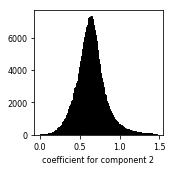

In [67]:
##histogram of coefficients for the chosen component for H-750
plt.figure(figsize=(2.3,2.3))

W7_com_mn = W7_com.mean(axis=0)
print(W7_com_mn)
W7_com_st = W7_com.std(axis=0)
print(W7_com_st)

##range for plot
chi_7 = W7_com_mn + 3*W7_com_st    ## mean plus 3 std
clo_7 = 0                          ##only havenon-negative coefficients by default
print(chi_7)
print(clo_7)

plt.hist(W7_com[W7_com!=0], bins=256, range=(clo_7,chi_7), fc='k', ec='k') 
plt.xlabel('coefficient for component {}'.format(com_n))


##saving histogram as a pdf
savefmt = os.path.join('dataset_28',
                       '{}{}{}{}{}{}{}{}{}{{:d}}.pdf'.format('hist_', basename_7, '_com', com_n+1, '_of_', Nn, '_', date, '_'))
i = 0
while os.path.exists(savefmt.format(i)):
    i += 1 
plt.savefig(savefmt.format(i), bbox_inches = 'tight')

0.004256049020305358
0.02484835486523585
0.07880111361601291
0


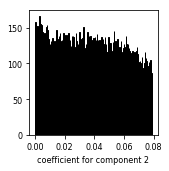

In [68]:
##histogram of coefficients for the chosen component for H-600
plt.figure(figsize=(2.3,2.3))

W6_com_mn = W6_com.mean(axis=0)
print(W6_com_mn)
W6_com_st = W6_com.std(axis=0)
print(W6_com_st)


##range for plot
chi_6 = W6_com_mn + 3*W6_com_st    ## mean plus 3 std
clo_6 = 0                          ##only havenon-negative coefficients by default
print(chi_6)
print(clo_6)

plt.hist(W6_com[W6_com!=0], bins=256, range=(clo_6,chi_6), fc='k', ec='k')
plt.xlabel('coefficient for component {}'.format(com_n))


##saving histogram as a pdf
savefmt = os.path.join('dataset_28',
                       '{}{}{}{}{}{}{}{}{}{{:d}}.pdf'.format('hist_', basename_6, '_com', com_n+1, '_of_', Nn, '_', date, '_'))
i = 0
while os.path.exists(savefmt.format(i)):
    i += 1 
plt.savefig(savefmt.format(i), bbox_inches = 'tight')

1.0270748659109181
0.23006399705230407
1.7172668570678304
0


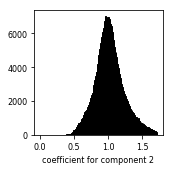

In [69]:
##histogram of coefficients for the chosen component for H-415
plt.figure(figsize=(2.3,2.3))

W4_com_mn = W4_com.mean(axis=0)
print(W4_com_mn)
W4_com_st = W4_com.std(axis=0)
print(W4_com_st)

##range for plot
chi_4 = W4_com_mn + 3*W4_com_st    ## mean plus 3 std
clo_4 = 0                          ##only havenon-negative coefficients by default
print(chi_4)
print(clo_4)

plt.hist(W4_com[W4_com!=0], bins=256, range=(clo_4,chi_4), fc='k', ec='k') 
plt.xlabel('coefficient for component {}'.format(com_n))


##saving histogram as a pdf
savefmt = os.path.join('dataset_28',
                       '{}{}{}{}{}{}{}{}{}{{:d}}.pdf'.format('hist_', basename_4, '_com', com_n+1, '_of_', Nn, '_', date, '_'))
i = 0
while os.path.exists(savefmt.format(i)):
    i += 1 
plt.savefig(savefmt.format(i), bbox_inches = 'tight')

1.047945305736057
0.19948391402980817
1.6463970478254817
0


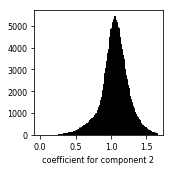

In [72]:
##histogram of coefficients for the chosen component for H-020
plt.figure(figsize=(2.3,2.3))

W2_com_mn = W2_com.mean(axis=0)
print(W2_com_mn)
W2_com_st = W2_com.std(axis=0)
print(W2_com_st)

##range for plot
chi_2 = W2_com_mn + 3*W2_com_st    ## mean plus 3 std
clo_2 = 0                          ##only havenon-negative coefficients by default
print(chi_2)
print(clo_2)

plt.hist(W2_com[W2_com!=0], bins=256, range=(clo_2,chi_2), fc='k', ec='k')
plt.xlabel('coefficient for component {}'.format(com_n))


##saving histogram as a pdf
savefmt = os.path.join('dataset_28',
                       '{}{}{}{}{}{}{}{}{}{{:d}}.pdf'.format('hist_', basename_2, '_com', com_n+1, '_of_', Nn, '_', date, '_'))
i = 0
while os.path.exists(savefmt.format(i)):
    i += 1 
plt.savefig(savefmt.format(i), bbox_inches = 'tight')

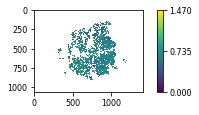

In [73]:
fig, ax = plt.subplots(figsize=(2.3,2.3))

image_7 = zeros(wanted_7.shape, dtype=W7.dtype)
image_7[wanted_7!=False] = W7_com

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
cmap = color_choice

image_7[wanted_7==False] = 0
image_7 = np.ma.masked_equal(image_7, 0)
cmap.set_bad(color=back_color)

want_im_7 = ax.imshow(image_7, cmap=cmap, interpolation='none', extent=[0, H_um_7, V_um_7, 0], clim = (clo_7,chi_7))
cbar = fig.colorbar(want_im_7, cax=cax, ticks=[clo_7, chi_7/2, chi_7], orientation='vertical')

##saving image as a pdf
savefmt = os.path.join('dataset_28',
                       '{}{}{}{}{}{}{}{}{}{{:d}}.pdf'.format('hist_', basename_7, '_com', com_n+1, '_of_', Nn, '_', date, '_'))
i = 0
while os.path.exists(savefmt.format(i)):
    i += 1 
plt.savefig(savefmt.format(i), bbox_inches = 'tight')

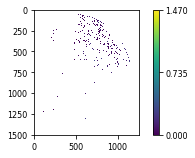

In [74]:
fig, ax = plt.subplots(figsize=(2.3,2.3))

image_6 = zeros(wanted_6.shape, dtype=W6.dtype)
image_6[wanted_6!=False] = W6_com

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
cmap = color_choice

image_6[wanted_6==False] = 0
image_6 = np.ma.masked_equal(image_6, 0)
cmap.set_bad(color=back_color)

want_im_6 = ax.imshow(image_6, cmap=cmap, interpolation='none', extent=[0, H_um_6, V_um_6, 0], clim = (clo_7,chi_7))
cbar = fig.colorbar(want_im_6, cax=cax, ticks=[clo_7, chi_7/2, chi_7], orientation='vertical')

##saving image as a pdf
savefmt = os.path.join('dataset_28',
                       '{}{}{}{}{}{}{}{}{{:d}}.pdf'.format(basename_6, '_com', com_n+1, '_of_', Nn, '_', date, '_'))
i = 0
while os.path.exists(savefmt.format(i)):
    i += 1 
plt.savefig(savefmt.format(i), bbox_inches = 'tight')

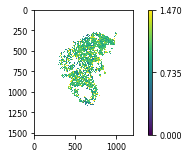

In [75]:
fig, ax = plt.subplots(figsize=(2.3,2.3))

image_4 = zeros(wanted_4.shape, dtype=W4.dtype)
image_4[wanted_4!=False] = W4_com

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
cmap = color_choice

image_4[wanted_4==False] = 0
image_4 = np.ma.masked_equal(image_4, 0)
cmap.set_bad(color=back_color)

want_im_4 = ax.imshow(image_4, cmap=cmap, interpolation='none', extent=[0, H_um_4, V_um_4, 0], clim = (clo_7,chi_7))
cbar = fig.colorbar(want_im_4, cax=cax, ticks=[clo_7, chi_7/2, chi_7], orientation='vertical')

##saving image as a pdf
savefmt = os.path.join('dataset_28',
                       '{}{}{}{}{}{}{}{}{{:d}}.pdf'.format(basename_4, '_com', com_n+1, '_of_', Nn, '_', date, '_'))
i = 0
while os.path.exists(savefmt.format(i)):
    i += 1 
plt.savefig(savefmt.format(i), bbox_inches = 'tight')

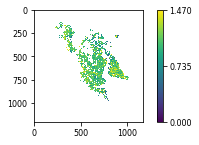

In [76]:
fig, ax = plt.subplots(figsize=(2.3,2.3))

image_2 = zeros(wanted_2.shape, dtype=W2.dtype)
image_2[wanted_2!=False] = W2_com


divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
cmap = color_choice

image_2[wanted_2==False] = 0
image_2 = np.ma.masked_equal(image_2, 0)
cmap.set_bad(color=back_color)

want_im_2 = ax.imshow(image_2, cmap=cmap, interpolation='none', extent=[0, H_um_2, V_um_2, 0], clim = (clo_7,chi_7))
cbar = fig.colorbar(want_im_2, cax=cax, ticks=[clo_7, chi_7/2, chi_7], orientation='vertical')

##saving image as a pdf
savefmt = os.path.join('dataset_28',
                       '{}{}{}{}{}{}{}{}{{:d}}.pdf'.format(basename_2, '_com', com_n+1, '_of_', Nn, '_', date, '_'))
i = 0
while os.path.exists(savefmt.format(i)):
    i += 1 
plt.savefig(savefmt.format(i), bbox_inches = 'tight')

## Treatment Vd:

In [77]:
##standards for publication figures

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

s=100
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

H750, first pair of particles

In [78]:
##H-750, first pair of particles
##particle1
varV_1i = 1395
varH_1i = 813
##particle2
varV_2i = 949
varH_2i = 628

varV_1a = 976.4999999999999
varV_1b = 983.4999999999999
varH_1 = 569.0999999999999
varV_2a = 664.3
varV_2b = 671.3
varH_2 = 439.59999999999997


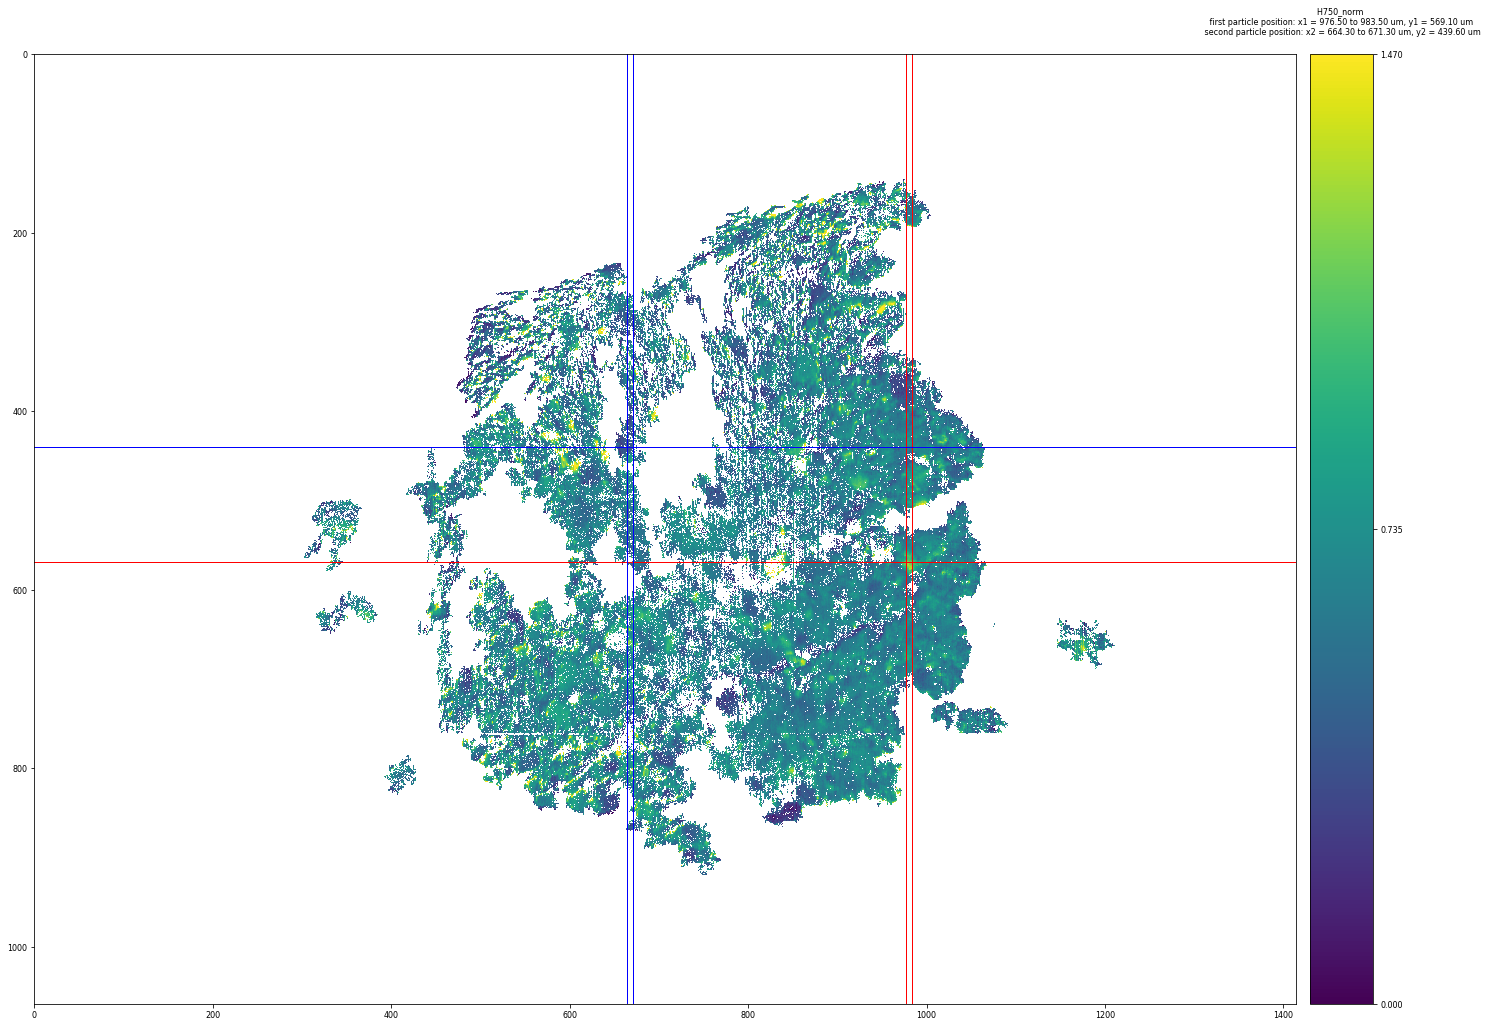

In [79]:
##masked data image in microns x microns to know location of particle
##from which the circles and boxes are drawn in the figures in the main manuscript and SI

fig, ax = plt.subplots(figsize=(24,24)) 

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)

want_im_7 = ax.imshow(image_7, cmap=cmap, interpolation='none', extent=[0, H_um_7, V_um_7, 0], clim = (clo_7,chi_7))
cbar = fig.colorbar(want_im_7, cax=cax, ticks=[clo_7, chi_7/2, chi_7], orientation='vertical')


varV_1a = varV_1i * 0.7
varV_1b = (varV_1i + 10) * 0.7
varH_1 = varH_1i * 0.7

varV_2a = varV_2i * 0.7
varV_2b = (varV_2i + 10) * 0.7
varH_2 = varH_2i * 0.7

plt.title('%s \n first particle position: x1 = %.2f to %.2f um, y1 = %.2f um \n second particle position: x2 = %.2f to %.2f um, y2 = %.2f um'%(basename_7, varV_1a, varV_1b, varH_1, varV_2a, varV_2b, varH_2), pad = 20)

ax.axvline(varV_1a, linewidth = 1, color = 'r')
ax.axvline(varV_1b, linewidth = 1, color = 'r')
ax.axhline(varH_1, linewidth = 1, color = 'r')

ax.axvline(varV_2a, linewidth = 1, color = 'b')
ax.axvline(varV_2b, linewidth = 1, color = 'b')
ax.axhline(varH_2, linewidth = 1, color = 'b')

##saving figure as a pdf and svg with index so can change formatting of colors etc without overwriting
savefmt = os.path.join('dataset_29',
                      '{}{}{}{}{{:d}}.{{}}'.format(basename_7, '_', date, '_cursors_um_'))
i = 0
while os.path.exists(savefmt.format(i, 'pdf')):
    i += 1
plt.savefig(savefmt.format(i, 'pdf'), bbox_inches = 'tight')
plt.savefig(savefmt.format(i, 'svg'), bbox_inches = 'tight')

print('varV_1a = %s' %(varV_1a))
print('varV_1b = %s' %(varV_1b))
print('varH_1 = %s' %(varH_1))
print('varV_2a = %s' %(varV_2a))
print('varV_2b = %s' %(varV_2b))
print('varH_2 = %s' %(varH_2))

varV_1a = 976.4999999999999
varV_1b = 983.4999999999999
varH_1 = 569.0999999999999
varV_2a = 664.3
varV_2b = 671.3
varH_2 = 439.59999999999997


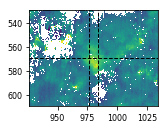

In [80]:
##particle 1 zoom

fig, ax = plt.subplots(figsize=(2.3,2.3)) 

want_im_7 = ax.imshow(image_7, cmap=cmap, interpolation='none', extent=[0, H_um_7, V_um_7, 0], clim = (clo_7,chi_7))

varV_1a = varV_1i * 0.7
varV_1b = (varV_1i + 10) * 0.7
varH_1 = varH_1i * 0.7

ax.axvline(varV_1a, linewidth = 1, linestyle = '--', color = 'k')
ax.axvline(varV_1b, linewidth = 1, linestyle = '--', color = 'k')
ax.axhline(varH_1, linewidth = 1, linestyle = '--', color = 'k')

ax.set_xlim([varV_1a - 50, varV_1b + 50])
ax.set_ylim([varH_1 + 40, varH_1 - 40])

#saving figure as a pdf and svg with index so can change formatting of colors etc without overwriting
savefmt = os.path.join('dataset_29',
                      '{}{}{}{}{{:d}}.{{}}'.format(basename_7, '_1st_', date, '_cursors_um_'))
i = 0
while os.path.exists(savefmt.format(i, 'pdf')):
    i += 1
plt.savefig(savefmt.format(i, 'pdf'), bbox_inches = 'tight')
plt.savefig(savefmt.format(i, 'svg'), bbox_inches = 'tight')

print('varV_1a = %s' %(varV_1a))
print('varV_1b = %s' %(varV_1b))
print('varH_1 = %s' %(varH_1))
print('varV_2a = %s' %(varV_2a))
print('varV_2b = %s' %(varV_2b))
print('varH_2 = %s' %(varH_2))

varV_1a = 976.4999999999999
varV_1b = 983.4999999999999
varH_1 = 569.0999999999999
varV_2a = 664.3
varV_2b = 671.3
varH_2 = 439.59999999999997


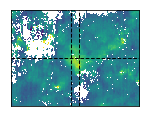

In [81]:
##particle 1 zoom

fig, ax = plt.subplots(figsize=(2.3,2.3)) 

want_im_7 = ax.imshow(image_7, cmap=cmap, interpolation='none', extent=[0, H_um_7, V_um_7, 0], clim = (clo_7,chi_7))

varV_1a = varV_1i * 0.7
varV_1b = (varV_1i + 10) * 0.7
varH_1 = varH_1i * 0.7

ax.axvline(varV_1a, linewidth = 1, linestyle = '--', color = 'k')
ax.axvline(varV_1b, linewidth = 1, linestyle = '--', color = 'k')
ax.axhline(varH_1, linewidth = 1, linestyle = '--', color = 'k')

ax.set_xlim([varV_1a - 50, varV_1b + 50])
ax.set_ylim([varH_1 + 40, varH_1 - 40])

want_im_7.axes.get_xaxis().set_ticks([])
want_im_7.axes.get_yaxis().set_ticks([])

#saving figure as a pdf and svg with index so can change formatting of colors etc without overwriting
savefmt = os.path.join('dataset_29',
                      '{}{}{}{}{{:d}}.{{}}'.format(basename_7, '_notix_1st_', date, '_cursors_um_'))
i = 0
while os.path.exists(savefmt.format(i, 'pdf')):
    i += 1
plt.savefig(savefmt.format(i, 'pdf'), bbox_inches = 'tight')
plt.savefig(savefmt.format(i, 'svg'), bbox_inches = 'tight')

print('varV_1a = %s' %(varV_1a))
print('varV_1b = %s' %(varV_1b))
print('varH_1 = %s' %(varH_1))
print('varV_2a = %s' %(varV_2a))
print('varV_2b = %s' %(varV_2b))
print('varH_2 = %s' %(varH_2))

varV_1a = 976.4999999999999
varV_1b = 983.4999999999999
varH_1 = 569.0999999999999
varV_2a = 664.3
varV_2b = 671.3
varH_2 = 439.59999999999997


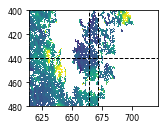

In [82]:
##particle 2 zoom

fig, ax = plt.subplots(figsize=(2.3,2.3)) 

want_im_7 = ax.imshow(image_7, cmap=cmap, interpolation='none', extent=[0, H_um_7, V_um_7, 0], clim = (clo_7,chi_7))

varV_2a = varV_2i * 0.7
varV_2b = (varV_2i + 10) * 0.7
varH_2 = varH_2i * 0.7

ax.axvline(varV_2a, linewidth = 1, linestyle = '--', color = 'k')
ax.axvline(varV_2b, linewidth = 1, linestyle = '--', color = 'k')
ax.axhline(varH_2, linewidth = 1, linestyle = '--', color = 'k')

ax.set_xlim([varV_2a - 50, varV_2b + 50])
ax.set_ylim([varH_2 + 40, varH_2 - 40])

#saving figure as a pdf and svg with index so can change formatting of colors etc without overwriting
savefmt = os.path.join('dataset_29',
                      '{}{}{}{}{{:d}}.{{}}'.format(basename_7, '_2nd_', date, '_cursors_um_'))
i = 0
while os.path.exists(savefmt.format(i, 'pdf')):
    i += 1
plt.savefig(savefmt.format(i, 'pdf'), bbox_inches = 'tight')
plt.savefig(savefmt.format(i, 'svg'), bbox_inches = 'tight')

print('varV_1a = %s' %(varV_1a))
print('varV_1b = %s' %(varV_1b))
print('varH_1 = %s' %(varH_1))
print('varV_2a = %s' %(varV_2a))
print('varV_2b = %s' %(varV_2b))
print('varH_2 = %s' %(varH_2))

varV_1a = 976.4999999999999
varV_1b = 983.4999999999999
varH_1 = 569.0999999999999
varV_2a = 664.3
varV_2b = 671.3
varH_2 = 439.59999999999997


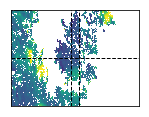

In [83]:
##particle 2 zoom

fig, ax = plt.subplots(figsize=(2.3,2.3)) 

want_im_7 = ax.imshow(image_7, cmap=cmap, interpolation='none', extent=[0, H_um_7, V_um_7, 0], clim = (clo_7,chi_7))

varV_2a = varV_2i * 0.7
varV_2b = (varV_2i + 10) * 0.7
varH_2 = varH_2i * 0.7

ax.axvline(varV_2a, linewidth = 1, linestyle = '--', color = 'k')
ax.axvline(varV_2b, linewidth = 1, linestyle = '--', color = 'k')
ax.axhline(varH_2, linewidth = 1, linestyle = '--', color = 'k')

ax.set_xlim([varV_2a - 50, varV_2b + 50])
ax.set_ylim([varH_2 + 40, varH_2 - 40])

want_im_7.axes.get_xaxis().set_ticks([])
want_im_7.axes.get_yaxis().set_ticks([])

#saving figure as a pdf and svg with index so can change formatting of colors etc without overwriting
savefmt = os.path.join('dataset_29',
                      '{}{}{}{}{{:d}}.{{}}'.format(basename_7, '_notix_2nd_', date, '_cursors_um_'))
i = 0
while os.path.exists(savefmt.format(i, 'pdf')):
    i += 1
plt.savefig(savefmt.format(i, 'pdf'), bbox_inches = 'tight')
plt.savefig(savefmt.format(i, 'svg'), bbox_inches = 'tight')

print('varV_1a = %s' %(varV_1a))
print('varV_1b = %s' %(varV_1b))
print('varH_1 = %s' %(varH_1))
print('varV_2a = %s' %(varV_2a))
print('varV_2b = %s' %(varV_2b))
print('varH_2 = %s' %(varH_2))

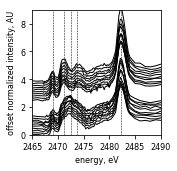

In [90]:
##plot of 10 spectra stepping from left vertical line to right vertical line along the horizontal line for the two particles designated in the image above
plt.figure(figsize=(2.3,2.3)) ##for publication

offset_1=0-0.15 ##giving offset a start value
offset_2=2.5-0.15 ##giving offset a start value
spec_num = 10 ##number of spectra you want plotted and colors needed

for v in range (varV_1i, varV_1i+spec_num):
    offset_1 = offset_1+0.15    ##CHOOSE Y OFFSET HERE
    water = plt.plot(energy, data_7[:,varH_1i,v]+offset_1, 'k', linewidth = 1)        

for v in range (varV_2i, varV_2i+spec_num):
    offset_2 = offset_2+0.15    ##CHOOSE Y OFFSET HERE
   
    water = plt.plot(energy, data_7[:,varH_2i,v]+offset_2, 'k', linewidth = 1)        

axvline(2469.0, linewidth = 0.5, linestyle = '--', color = 'k')
axvline(2471.2, linewidth = 0.5, linestyle = '--', color = 'k')
axvline(2472.5, linewidth = 0.5, linestyle = '--', color = 'k')
axvline(2473.8, linewidth = 0.5, linestyle = '--', color = 'k')
axvline(2482.2, linewidth = 0.5, linestyle = '--', color = 'k')
    
plt.ylabel('offset normalized intensity, AU')
plt.xlabel('energy, eV')
plt.xlim(2465,2490.001)   #not needed if subsample data above
plt.ylim(0,9)
xticks(np.arange(2465,2490.001, step=5))

##saving figure as a pdf and svg with index
savefmt = os.path.join('dataset_29',
                      '{}{}{}{}{}{}{}{}{}{}{{:d}}.{{}}'.format('spec_', basename_7, '_diff', com_nb+1, com_na+1, '_of_', Nn, '_', date, '_'))
i = 0
while os.path.exists(savefmt.format(i, 'pdf')):
    i += 1
plt.savefig(savefmt.format(i, 'pdf'), bbox_inches = 'tight')
plt.savefig(savefmt.format(i, 'svg'), bbox_inches = 'tight')
plt.show()

H750, second pair of particles

In [91]:
##H-750, second pair of particles
##particle3
varV_1i = 830
varH_1i = 1050
##particle4
varV_2i = 1224
varH_2i = 500

varV_1a = 581.0
varV_1b = 588.0
varH_1 = 735.0
varV_2a = 856.8
varV_2b = 863.8
varH_2 = 350.0


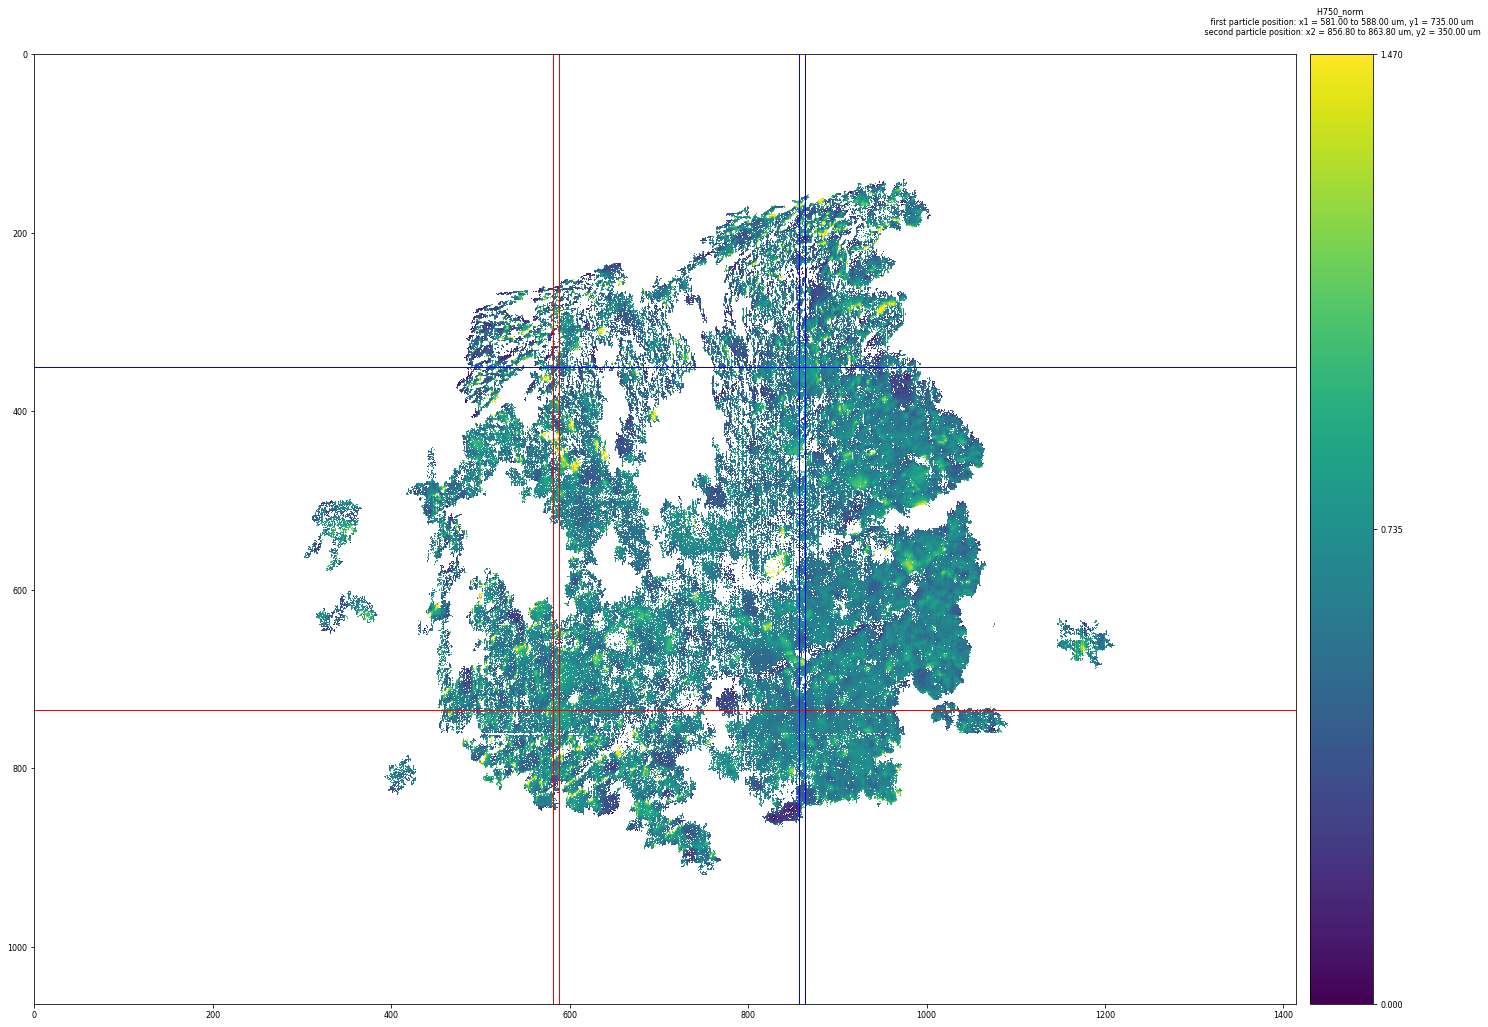

In [92]:
##masked data image in microns x microns to know location of particle
##from which the circles and boxes are drawn in the figures in the main manuscript and SI

fig, ax = plt.subplots(figsize=(24,24)) 

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)

want_im_7 = ax.imshow(image_7, cmap=cmap, interpolation='none', extent=[0, H_um_7, V_um_7, 0], clim = (clo_7,chi_7))
cbar = fig.colorbar(want_im_7, cax=cax, ticks=[clo_7, chi_7/2, chi_7], orientation='vertical')


varV_1a = varV_1i * 0.7
varV_1b = (varV_1i + 10) * 0.7
varH_1 = varH_1i * 0.7

varV_2a = varV_2i * 0.7
varV_2b = (varV_2i + 10) * 0.7
varH_2 = varH_2i * 0.7

plt.title('%s \n first particle position: x1 = %.2f to %.2f um, y1 = %.2f um \n second particle position: x2 = %.2f to %.2f um, y2 = %.2f um'%(basename_7, varV_1a, varV_1b, varH_1, varV_2a, varV_2b, varH_2), pad = 20)

ax.axvline(varV_1a, linewidth = 1, color = 'r')
ax.axvline(varV_1b, linewidth = 1, color = 'r')
ax.axhline(varH_1, linewidth = 1, color = 'r')

ax.axvline(varV_2a, linewidth = 1, color = 'b')
ax.axvline(varV_2b, linewidth = 1, color = 'b')
ax.axhline(varH_2, linewidth = 1, color = 'b')

##saving figure as a pdf and svg with index so can change formatting of colors etc without overwriting
savefmt = os.path.join('dataset_29',
                      '{}{}{}{}{{:d}}.{{}}'.format(basename_7, '_', date, '_cursors_um_'))
i = 0
while os.path.exists(savefmt.format(i, 'pdf')):
    i += 1
plt.savefig(savefmt.format(i, 'pdf'), bbox_inches = 'tight')
plt.savefig(savefmt.format(i, 'svg'), bbox_inches = 'tight')

print('varV_1a = %s' %(varV_1a))
print('varV_1b = %s' %(varV_1b))
print('varH_1 = %s' %(varH_1))
print('varV_2a = %s' %(varV_2a))
print('varV_2b = %s' %(varV_2b))
print('varH_2 = %s' %(varH_2))

varV_1a = 581.0
varV_1b = 588.0
varH_1 = 735.0
varV_2a = 856.8
varV_2b = 863.8
varH_2 = 350.0


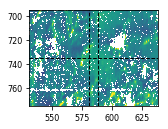

In [93]:
##particle 3 zoom

fig, ax = plt.subplots(figsize=(2.3,2.3)) 

want_im_7 = ax.imshow(image_7, cmap=cmap, interpolation='none', extent=[0, H_um_7, V_um_7, 0], clim = (clo_7,chi_7))

varV_1a = varV_1i * 0.7
varV_1b = (varV_1i + 10) * 0.7
varH_1 = varH_1i * 0.7

ax.axvline(varV_1a, linewidth = 1, linestyle = '--', color = 'k')
ax.axvline(varV_1b, linewidth = 1, linestyle = '--', color = 'k')
ax.axhline(varH_1, linewidth = 1, linestyle = '--', color = 'k')

ax.set_xlim([varV_1a - 50, varV_1b + 50])
ax.set_ylim([varH_1 + 40, varH_1 - 40])

#saving figure as a pdf and svg with index so can change formatting of colors etc without overwriting
savefmt = os.path.join('dataset_29',
                      '{}{}{}{}{{:d}}.{{}}'.format(basename_7, '_3rd_', date, '_cursors_um_'))
i = 0
while os.path.exists(savefmt.format(i, 'pdf')):
    i += 1
plt.savefig(savefmt.format(i, 'pdf'), bbox_inches = 'tight')
plt.savefig(savefmt.format(i, 'svg'), bbox_inches = 'tight')

print('varV_1a = %s' %(varV_1a))
print('varV_1b = %s' %(varV_1b))
print('varH_1 = %s' %(varH_1))
print('varV_2a = %s' %(varV_2a))
print('varV_2b = %s' %(varV_2b))
print('varH_2 = %s' %(varH_2))

varV_1a = 581.0
varV_1b = 588.0
varH_1 = 735.0
varV_2a = 856.8
varV_2b = 863.8
varH_2 = 350.0


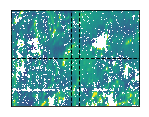

In [94]:
##particle 3 zoom

fig, ax = plt.subplots(figsize=(2.3,2.3)) 

want_im_7 = ax.imshow(image_7, cmap=cmap, interpolation='none', extent=[0, H_um_7, V_um_7, 0], clim = (clo_7,chi_7))

varV_1a = varV_1i * 0.7
varV_1b = (varV_1i + 10) * 0.7
varH_1 = varH_1i * 0.7

ax.axvline(varV_1a, linewidth = 1, linestyle = '--', color = 'k')
ax.axvline(varV_1b, linewidth = 1, linestyle = '--', color = 'k')
ax.axhline(varH_1, linewidth = 1, linestyle = '--', color = 'k')

ax.set_xlim([varV_1a - 50, varV_1b + 50])
ax.set_ylim([varH_1 + 40, varH_1 - 40])

want_im_7.axes.get_xaxis().set_ticks([])
want_im_7.axes.get_yaxis().set_ticks([])

#saving figure as a pdf and svg with index so can change formatting of colors etc without overwriting
savefmt = os.path.join('dataset_29',
                      '{}{}{}{}{{:d}}.{{}}'.format(basename_7, '_notix_3rd_', date, '_cursors_um_'))
i = 0
while os.path.exists(savefmt.format(i, 'pdf')):
    i += 1
plt.savefig(savefmt.format(i, 'pdf'), bbox_inches = 'tight')
plt.savefig(savefmt.format(i, 'svg'), bbox_inches = 'tight')

print('varV_1a = %s' %(varV_1a))
print('varV_1b = %s' %(varV_1b))
print('varH_1 = %s' %(varH_1))
print('varV_2a = %s' %(varV_2a))
print('varV_2b = %s' %(varV_2b))
print('varH_2 = %s' %(varH_2))

varV_1a = 581.0
varV_1b = 588.0
varH_1 = 735.0
varV_2a = 856.8
varV_2b = 863.8
varH_2 = 350.0


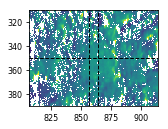

In [95]:
##particle 4 zoom

fig, ax = plt.subplots(figsize=(2.3,2.3)) 

want_im_7 = ax.imshow(image_7, cmap=cmap, interpolation='none', extent=[0, H_um_7, V_um_7, 0], clim = (clo_7,chi_7))

varV_2a = varV_2i * 0.7
varV_2b = (varV_2i + 10) * 0.7
varH_2 = varH_2i * 0.7

ax.axvline(varV_2a, linewidth = 1, linestyle = '--', color = 'k')
ax.axvline(varV_2b, linewidth = 1, linestyle = '--', color = 'k')
ax.axhline(varH_2, linewidth = 1, linestyle = '--', color = 'k')

ax.set_xlim([varV_2a - 50, varV_2b + 50])
ax.set_ylim([varH_2 + 40, varH_2 - 40])

#saving figure as a pdf and svg with index so can change formatting of colors etc without overwriting
savefmt = os.path.join('dataset_29',
                      '{}{}{}{}{{:d}}.{{}}'.format(basename_7, '_4th_', date, '_cursors_um_'))
i = 0
while os.path.exists(savefmt.format(i, 'pdf')):
    i += 1
plt.savefig(savefmt.format(i, 'pdf'), bbox_inches = 'tight')
plt.savefig(savefmt.format(i, 'svg'), bbox_inches = 'tight')

print('varV_1a = %s' %(varV_1a))
print('varV_1b = %s' %(varV_1b))
print('varH_1 = %s' %(varH_1))
print('varV_2a = %s' %(varV_2a))
print('varV_2b = %s' %(varV_2b))
print('varH_2 = %s' %(varH_2))

varV_1a = 581.0
varV_1b = 588.0
varH_1 = 735.0
varV_2a = 856.8
varV_2b = 863.8
varH_2 = 350.0


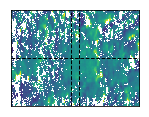

In [96]:
##particle 4 zoom

fig, ax = plt.subplots(figsize=(2.3,2.3)) 

want_im_7 = ax.imshow(image_7, cmap=cmap, interpolation='none', extent=[0, H_um_7, V_um_7, 0], clim = (clo_7,chi_7))

varV_2a = varV_2i * 0.7
varV_2b = (varV_2i + 10) * 0.7
varH_2 = varH_2i * 0.7

ax.axvline(varV_2a, linewidth = 1, linestyle = '--', color = 'k')
ax.axvline(varV_2b, linewidth = 1, linestyle = '--', color = 'k')
ax.axhline(varH_2, linewidth = 1, linestyle = '--', color = 'k')

ax.set_xlim([varV_2a - 50, varV_2b + 50])
ax.set_ylim([varH_2 + 40, varH_2 - 40])

want_im_7.axes.get_xaxis().set_ticks([])
want_im_7.axes.get_yaxis().set_ticks([])

#saving figure as a pdf and svg with index so can change formatting of colors etc without overwriting
savefmt = os.path.join('dataset_29',
                      '{}{}{}{}{{:d}}.{{}}'.format(basename_7, '_notix_24th', date, '_cursors_um_'))
i = 0
while os.path.exists(savefmt.format(i, 'pdf')):
    i += 1
plt.savefig(savefmt.format(i, 'pdf'), bbox_inches = 'tight')
plt.savefig(savefmt.format(i, 'svg'), bbox_inches = 'tight')

print('varV_1a = %s' %(varV_1a))
print('varV_1b = %s' %(varV_1b))
print('varH_1 = %s' %(varH_1))
print('varV_2a = %s' %(varV_2a))
print('varV_2b = %s' %(varV_2b))
print('varH_2 = %s' %(varH_2))

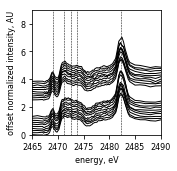

In [99]:
##plot of 10 spectra stepping from left vertical line to right vertical line along the horizontal line for the two particles designated in the image above
plt.figure(figsize=(2.3,2.3)) ##for publication

offset_1=0-0.15 ##giving offset a start value
offset_2=2.5-0.15 ##giving offset a start value
spec_num = 10 ##number of spectra you want plotted and colors needed

for v in range (varV_1i, varV_1i+spec_num):
    offset_1 = offset_1+0.15    ##CHOOSE Y OFFSET HERE
    water = plt.plot(energy, data_7[:,varH_1i,v]+offset_1, 'k', linewidth = 1)        

for v in range (varV_2i, varV_2i+spec_num):
    offset_2 = offset_2+0.15    ##CHOOSE Y OFFSET HERE
   
    water = plt.plot(energy, data_7[:,varH_2i,v]+offset_2, 'k', linewidth = 1)        

axvline(2469.0, linewidth = 0.5, linestyle = '--', color = 'k')
axvline(2471.2, linewidth = 0.5, linestyle = '--', color = 'k')
axvline(2472.5, linewidth = 0.5, linestyle = '--', color = 'k')
axvline(2473.8, linewidth = 0.5, linestyle = '--', color = 'k')
axvline(2482.2, linewidth = 0.5, linestyle = '--', color = 'k')
    
plt.ylabel('offset normalized intensity, AU')
plt.xlabel('energy, eV')
plt.xlim(2465,2490.001)   #not needed if subsample data above
plt.ylim(0,9)
xticks(np.arange(2465,2490.001, step=5))

##saving figure as a pdf and svg with index
savefmt = os.path.join('dataset_29',
                      '{}{}{}{}{}{}{}{}{}{}{{:d}}.{{}}'.format('spec_', basename_7, '_diff', com_nb+1, com_na+1, '_of_', Nn, '_', date, '_'))
i = 0
while os.path.exists(savefmt.format(i, 'pdf')):
    i += 1
plt.savefig(savefmt.format(i, 'pdf'), bbox_inches = 'tight')
plt.savefig(savefmt.format(i, 'svg'), bbox_inches = 'tight')
plt.show()

H600, pair of particles

In [100]:
##H-600, pair of particles
##particle1
varV_1i = 434
varH_1i = 1866
##particle2
varV_2i = 804
varH_2i = 1160

varV_1a = 303.79999999999995
varV_1b = 310.79999999999995
varH_1 = 1306.1999999999998
varV_2a = 562.8
varV_2b = 569.8
varH_2 = 812.0


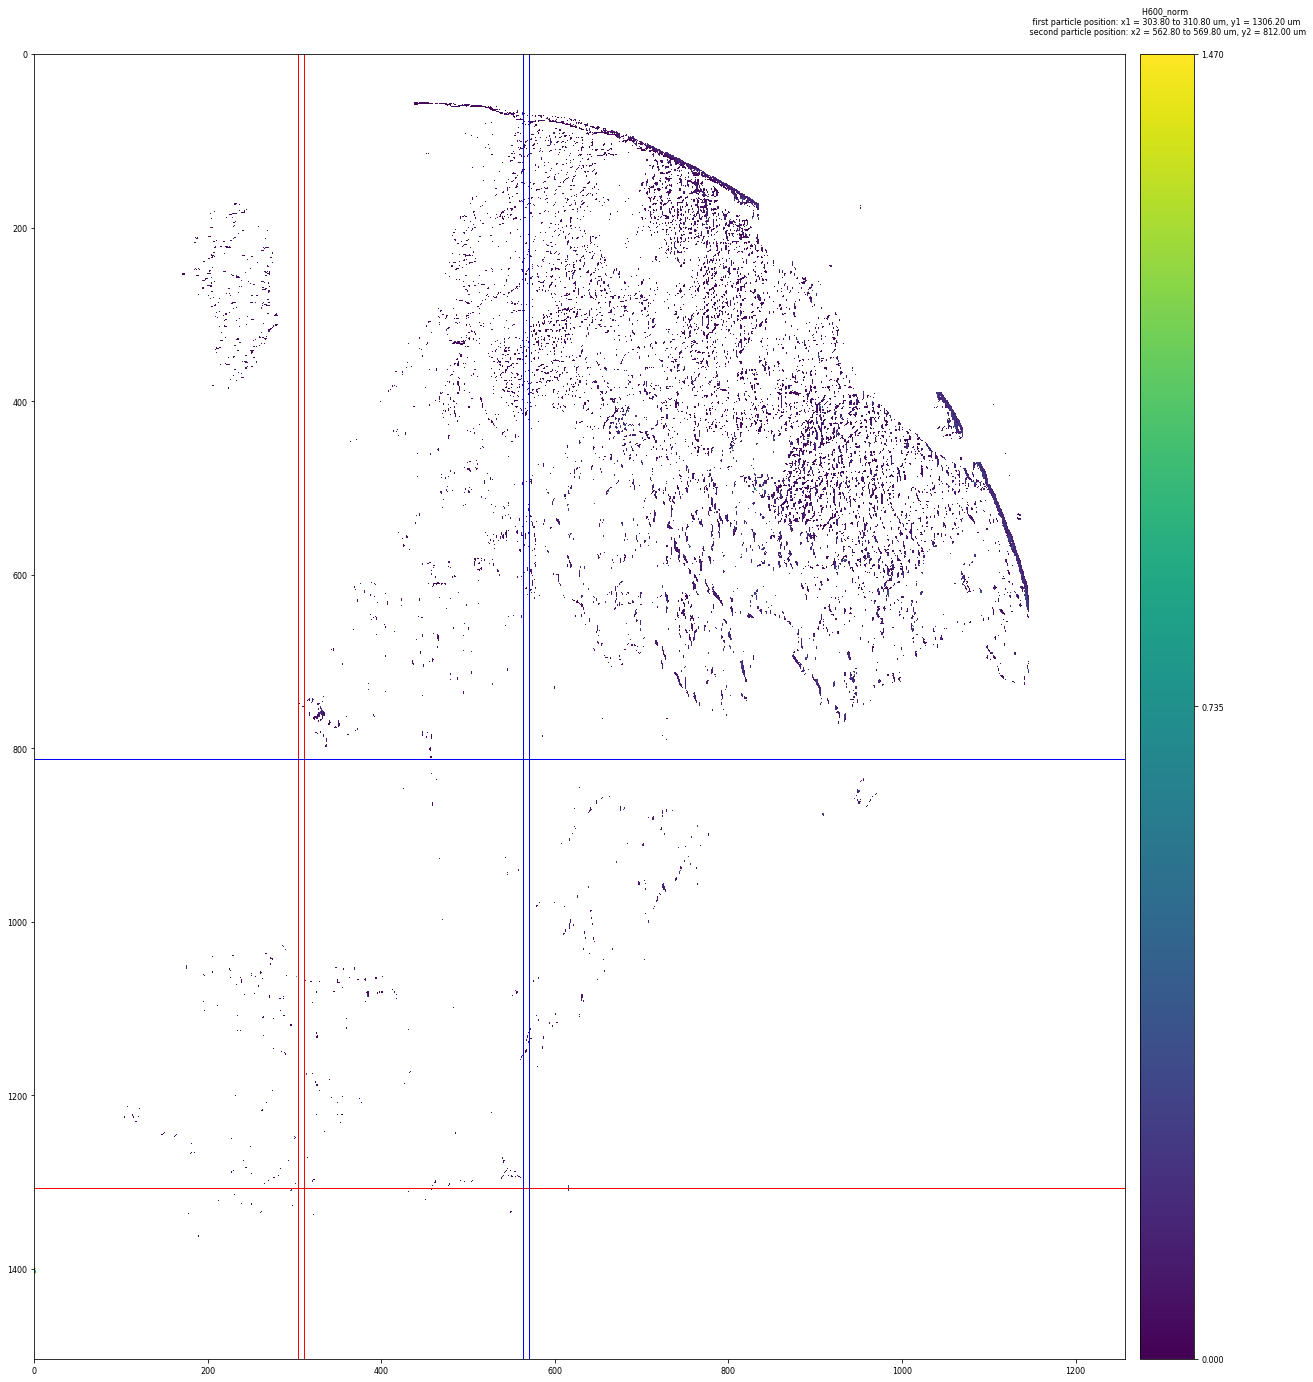

In [101]:
##masked data image in microns x microns to know location of particle
##from which the circles and boxes are drawn in the figures in the main manuscript and SI

fig, ax = plt.subplots(figsize=(24,24)) 

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)

want_im_6 = ax.imshow(image_6, cmap=cmap, interpolation='none', extent=[0, H_um_6, V_um_6, 0], clim = (clo_7,chi_7))
cbar = fig.colorbar(want_im_6, cax=cax, ticks=[clo_7, chi_7/2, chi_7], orientation='vertical')


varV_1a = varV_1i * 0.7
varV_1b = (varV_1i + 10) * 0.7
varH_1 = varH_1i * 0.7

varV_2a = varV_2i * 0.7
varV_2b = (varV_2i + 10) * 0.7
varH_2 = varH_2i * 0.7

plt.title('%s \n first particle position: x1 = %.2f to %.2f um, y1 = %.2f um \n second particle position: x2 = %.2f to %.2f um, y2 = %.2f um'%(basename_6, varV_1a, varV_1b, varH_1, varV_2a, varV_2b, varH_2), pad = 20)

ax.axvline(varV_1a, linewidth = 1, color = 'r')
ax.axvline(varV_1b, linewidth = 1, color = 'r')
ax.axhline(varH_1, linewidth = 1, color = 'r')

ax.axvline(varV_2a, linewidth = 1, color = 'b')
ax.axvline(varV_2b, linewidth = 1, color = 'b')
ax.axhline(varH_2, linewidth = 1, color = 'b')

##saving figure as a pdf and svg with index so can change formatting of colors etc without overwriting
savefmt = os.path.join('dataset_29',
                      '{}{}{}{}{{:d}}.{{}}'.format(basename_6, '_', date, '_cursors_um_'))
i = 0
while os.path.exists(savefmt.format(i, 'pdf')):
    i += 1
plt.savefig(savefmt.format(i, 'pdf'), bbox_inches = 'tight')
plt.savefig(savefmt.format(i, 'svg'), bbox_inches = 'tight')

print('varV_1a = %s' %(varV_1a))
print('varV_1b = %s' %(varV_1b))
print('varH_1 = %s' %(varH_1))
print('varV_2a = %s' %(varV_2a))
print('varV_2b = %s' %(varV_2b))
print('varH_2 = %s' %(varH_2))

varV_1a = 303.79999999999995
varV_1b = 310.79999999999995
varH_1 = 1306.1999999999998
varV_2a = 562.8
varV_2b = 569.8
varH_2 = 812.0


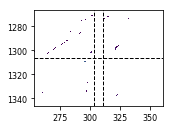

In [102]:
##particle 1 zoom

fig, ax = plt.subplots(figsize=(2.3,2.3)) 

want_im_6 = ax.imshow(image_6, cmap=cmap, interpolation='none', extent=[0, H_um_6, V_um_6, 0], clim = (clo_7,chi_7))

varV_1a = varV_1i * 0.7
varV_1b = (varV_1i + 10) * 0.7
varH_1 = varH_1i * 0.7

ax.axvline(varV_1a, linewidth = 1, linestyle = '--', color = 'k')
ax.axvline(varV_1b, linewidth = 1, linestyle = '--', color = 'k')
ax.axhline(varH_1, linewidth = 1, linestyle = '--', color = 'k')

ax.set_xlim([varV_1a - 50, varV_1b + 50])
ax.set_ylim([varH_1 + 40, varH_1 - 40])

#saving figure as a pdf and svg with index so can change formatting of colors etc without overwriting
savefmt = os.path.join('dataset_29',
                      '{}{}{}{}{{:d}}.{{}}'.format(basename_6, '_1st_', date, '_cursors_um_'))
i = 0
while os.path.exists(savefmt.format(i, 'pdf')):
    i += 1
plt.savefig(savefmt.format(i, 'pdf'), bbox_inches = 'tight')
plt.savefig(savefmt.format(i, 'svg'), bbox_inches = 'tight')

print('varV_1a = %s' %(varV_1a))
print('varV_1b = %s' %(varV_1b))
print('varH_1 = %s' %(varH_1))
print('varV_2a = %s' %(varV_2a))
print('varV_2b = %s' %(varV_2b))
print('varH_2 = %s' %(varH_2))

varV_1a = 303.79999999999995
varV_1b = 310.79999999999995
varH_1 = 1306.1999999999998
varV_2a = 562.8
varV_2b = 569.8
varH_2 = 812.0


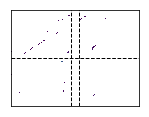

In [103]:
##particle 1 zoom

fig, ax = plt.subplots(figsize=(2.3,2.3)) 

want_im_6 = ax.imshow(image_6, cmap=cmap, interpolation='none', extent=[0, H_um_6, V_um_6, 0], clim = (clo_7,chi_7))

varV_1a = varV_1i * 0.7
varV_1b = (varV_1i + 10) * 0.7
varH_1 = varH_1i * 0.7

ax.axvline(varV_1a, linewidth = 1, linestyle = '--', color = 'k')
ax.axvline(varV_1b, linewidth = 1, linestyle = '--', color = 'k')
ax.axhline(varH_1, linewidth = 1, linestyle = '--', color = 'k')

ax.set_xlim([varV_1a - 50, varV_1b + 50])
ax.set_ylim([varH_1 + 40, varH_1 - 40])

want_im_6.axes.get_xaxis().set_ticks([])
want_im_6.axes.get_yaxis().set_ticks([])

#saving figure as a pdf and svg with index so can change formatting of colors etc without overwriting
savefmt = os.path.join('dataset_29',
                      '{}{}{}{}{{:d}}.{{}}'.format(basename_6, '_notix_1st_', date, '_cursors_um_'))
i = 0
while os.path.exists(savefmt.format(i, 'pdf')):
    i += 1
plt.savefig(savefmt.format(i, 'pdf'), bbox_inches = 'tight')
plt.savefig(savefmt.format(i, 'svg'), bbox_inches = 'tight')

print('varV_1a = %s' %(varV_1a))
print('varV_1b = %s' %(varV_1b))
print('varH_1 = %s' %(varH_1))
print('varV_2a = %s' %(varV_2a))
print('varV_2b = %s' %(varV_2b))
print('varH_2 = %s' %(varH_2))

varV_1a = 303.79999999999995
varV_1b = 310.79999999999995
varH_1 = 1306.1999999999998
varV_2a = 562.8
varV_2b = 569.8
varH_2 = 812.0


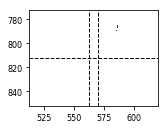

In [104]:
##particle 2 zoom

fig, ax = plt.subplots(figsize=(2.3,2.3)) 

want_im_6 = ax.imshow(image_6, cmap=cmap, interpolation='none', extent=[0, H_um_6, V_um_6, 0], clim = (clo_7,chi_7))

varV_2a = varV_2i * 0.7
varV_2b = (varV_2i + 10) * 0.7
varH_2 = varH_2i * 0.7

ax.axvline(varV_2a, linewidth = 1, linestyle = '--', color = 'k')
ax.axvline(varV_2b, linewidth = 1, linestyle = '--', color = 'k')
ax.axhline(varH_2, linewidth = 1, linestyle = '--', color = 'k')

ax.set_xlim([varV_2a - 50, varV_2b + 50])
ax.set_ylim([varH_2 + 40, varH_2 - 40])

#saving figure as a pdf and svg with index so can change formatting of colors etc without overwriting
savefmt = os.path.join('dataset_29',
                      '{}{}{}{}{{:d}}.{{}}'.format(basename_6, '_2nd_', date, '_cursors_um_'))
i = 0
while os.path.exists(savefmt.format(i, 'pdf')):
    i += 1
plt.savefig(savefmt.format(i, 'pdf'), bbox_inches = 'tight')
plt.savefig(savefmt.format(i, 'svg'), bbox_inches = 'tight')

print('varV_1a = %s' %(varV_1a))
print('varV_1b = %s' %(varV_1b))
print('varH_1 = %s' %(varH_1))
print('varV_2a = %s' %(varV_2a))
print('varV_2b = %s' %(varV_2b))
print('varH_2 = %s' %(varH_2))

varV_1a = 303.79999999999995
varV_1b = 310.79999999999995
varH_1 = 1306.1999999999998
varV_2a = 562.8
varV_2b = 569.8
varH_2 = 812.0


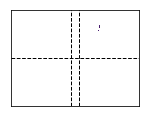

In [105]:
##particle 2 zoom

fig, ax = plt.subplots(figsize=(2.3,2.3)) 

want_im_6 = ax.imshow(image_6, cmap=cmap, interpolation='none', extent=[0, H_um_6, V_um_6, 0], clim = (clo_7,chi_7))

varV_2a = varV_2i * 0.7
varV_2b = (varV_2i + 10) * 0.7
varH_2 = varH_2i * 0.7

ax.axvline(varV_2a, linewidth = 1, linestyle = '--', color = 'k')
ax.axvline(varV_2b, linewidth = 1, linestyle = '--', color = 'k')
ax.axhline(varH_2, linewidth = 1, linestyle = '--', color = 'k')

ax.set_xlim([varV_2a - 50, varV_2b + 50])
ax.set_ylim([varH_2 + 40, varH_2 - 40])

want_im_6.axes.get_xaxis().set_ticks([])
want_im_6.axes.get_yaxis().set_ticks([])

#saving figure as a pdf and svg with index so can change formatting of colors etc without overwriting
savefmt = os.path.join('dataset_29',
                      '{}{}{}{}{{:d}}.{{}}'.format(basename_6, '_notix_2nd_', date, '_cursors_um_'))
i = 0
while os.path.exists(savefmt.format(i, 'pdf')):
    i += 1
plt.savefig(savefmt.format(i, 'pdf'), bbox_inches = 'tight')
plt.savefig(savefmt.format(i, 'svg'), bbox_inches = 'tight')

print('varV_1a = %s' %(varV_1a))
print('varV_1b = %s' %(varV_1b))
print('varH_1 = %s' %(varH_1))
print('varV_2a = %s' %(varV_2a))
print('varV_2b = %s' %(varV_2b))
print('varH_2 = %s' %(varH_2))

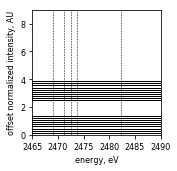

In [106]:
##plot of 10 spectra stepping from left vertical line to right vertical line along the horizontal line for the two particles designated in the image above
plt.figure(figsize=(2.3,2.3)) ##for publication

offset_1=0-0.15 ##giving offset a start value
offset_2=2.5-0.15 ##giving offset a start value
spec_num = 10 ##number of spectra you want plotted and colors needed

for v in range (varV_1i, varV_1i+spec_num):
    offset_1 = offset_1+0.15    ##CHOOSE Y OFFSET HERE
    water = plt.plot(energy, data_6[:,varH_1i,v]+offset_1, 'k', linewidth = 1)        

for v in range (varV_2i, varV_2i+spec_num):
    offset_2 = offset_2+0.15    ##CHOOSE Y OFFSET HERE
    water = plt.plot(energy, data_6[:,varH_2i,v]+offset_2, 'k', linewidth = 1)        

axvline(2469.0, linewidth = 0.5, linestyle = '--', color = 'k')
axvline(2471.2, linewidth = 0.5, linestyle = '--', color = 'k')
axvline(2472.5, linewidth = 0.5, linestyle = '--', color = 'k')
axvline(2473.8, linewidth = 0.5, linestyle = '--', color = 'k')
axvline(2482.2, linewidth = 0.5, linestyle = '--', color = 'k')
    
plt.ylabel('offset normalized intensity, AU')
plt.xlabel('energy, eV')
plt.xlim(2465,2490.001)   #not needed if subsample data above
plt.ylim(0,9)
xticks(np.arange(2465,2490.001, step=5))

##saving figure as a pdf and svg with index
savefmt = os.path.join('dataset_29',
                      '{}{}{}{}{}{}{}{}{}{}{{:d}}.{{}}'.format('spec_', basename_6, '_diff', com_nb+1, com_na+1, '_of_', Nn, '_', date, '_'))
i = 0
while os.path.exists(savefmt.format(i, 'pdf')):
    i += 1
plt.savefig(savefmt.format(i, 'pdf'), bbox_inches = 'tight')
plt.savefig(savefmt.format(i, 'svg'), bbox_inches = 'tight')
plt.show()

H415, pair of particles

In [107]:
##H-415, pair of particles
##particle1
varV_1i = 1210
varH_1i = 591
##particle2
varV_2i = 1185
varH_2i = 635

varV_1a = 847.0
varV_1b = 854.0
varH_1 = 413.7
varV_2a = 829.5
varV_2b = 836.5
varH_2 = 444.5


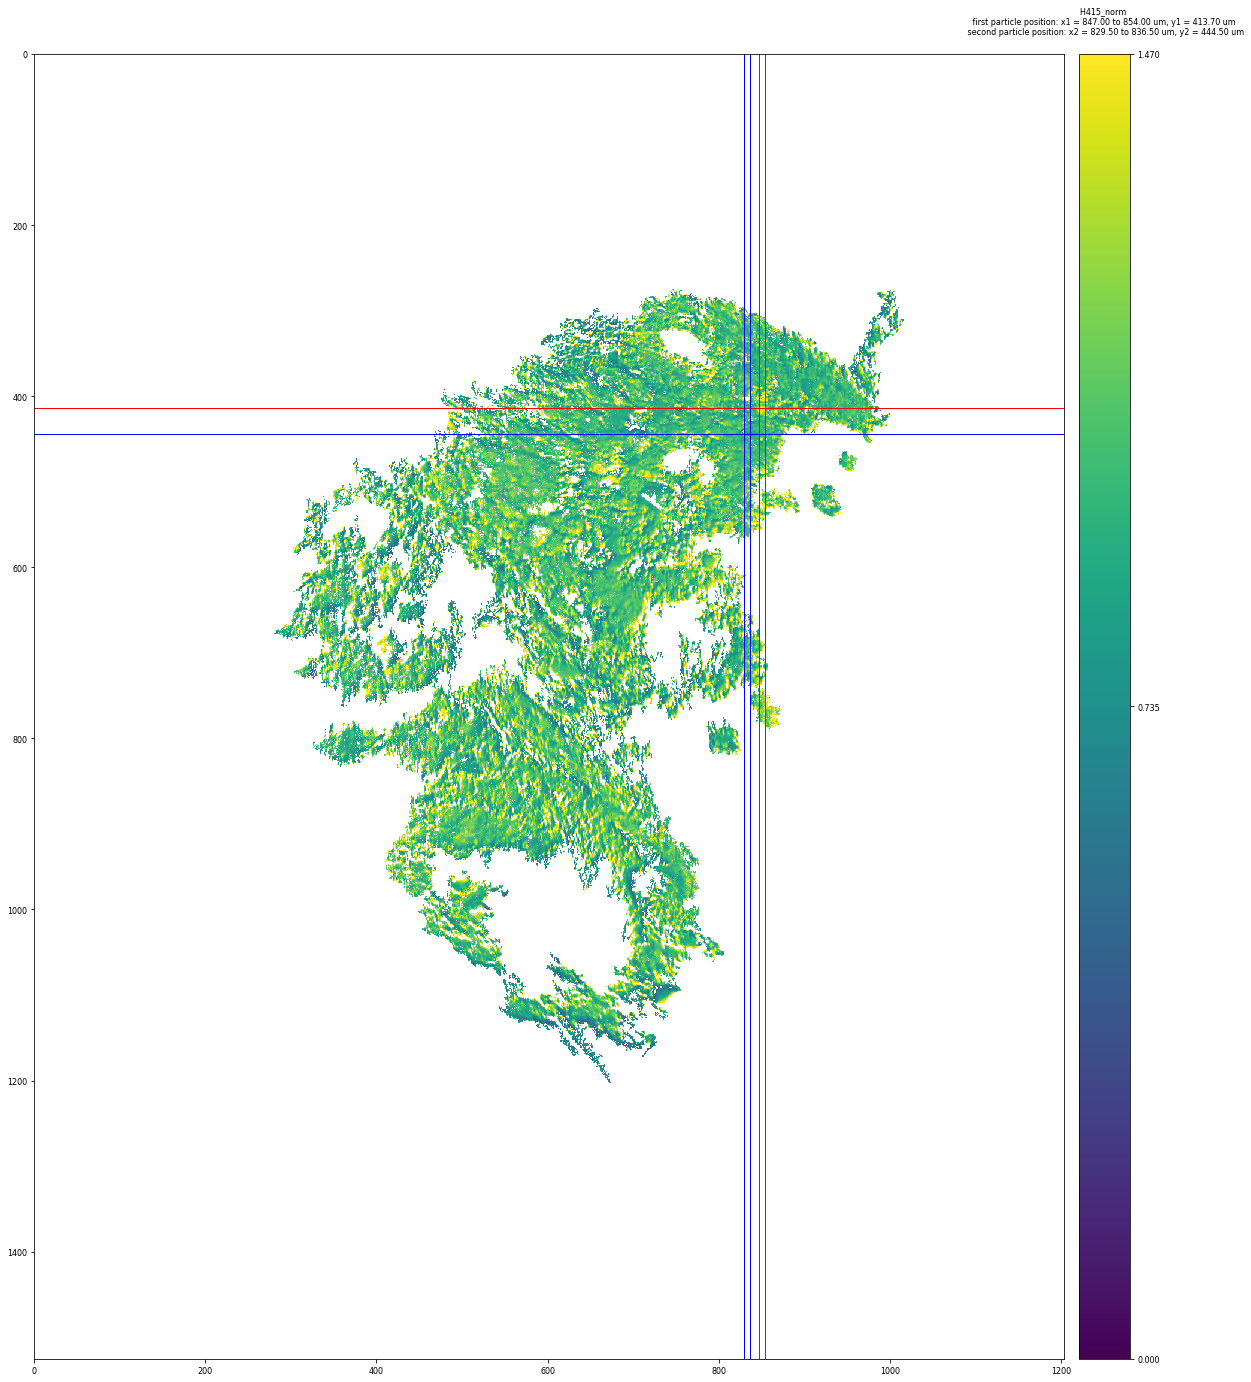

In [108]:
##masked data image in microns x microns to know location of particle
##from which the circles and boxes are drawn in the figures in the main manuscript and SI

fig, ax = plt.subplots(figsize=(24,24)) 

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)

want_im_4 = ax.imshow(image_4, cmap=cmap, interpolation='none', extent=[0, H_um_4, V_um_4, 0], clim = (clo_7,chi_7))
cbar = fig.colorbar(want_im_4, cax=cax, ticks=[clo_7, chi_7/2, chi_7], orientation='vertical')


varV_1a = varV_1i * 0.7
varV_1b = (varV_1i + 10) * 0.7
varH_1 = varH_1i * 0.7

varV_2a = varV_2i * 0.7
varV_2b = (varV_2i + 10) * 0.7
varH_2 = varH_2i * 0.7

plt.title('%s \n first particle position: x1 = %.2f to %.2f um, y1 = %.2f um \n second particle position: x2 = %.2f to %.2f um, y2 = %.2f um'%(basename_4, varV_1a, varV_1b, varH_1, varV_2a, varV_2b, varH_2), pad = 20)

ax.axvline(varV_1a, linewidth = 1, color = 'r')
ax.axvline(varV_1b, linewidth = 1, color = 'r')
ax.axhline(varH_1, linewidth = 1, color = 'r')

ax.axvline(varV_2a, linewidth = 1, color = 'b')
ax.axvline(varV_2b, linewidth = 1, color = 'b')
ax.axhline(varH_2, linewidth = 1, color = 'b')

##saving figure as a pdf and svg with index so can change formatting of colors etc without overwriting
savefmt = os.path.join('dataset_29',
                      '{}{}{}{}{{:d}}.{{}}'.format(basename_4, '_', date, '_cursors_um_'))
i = 0
while os.path.exists(savefmt.format(i, 'pdf')):
    i += 1
plt.savefig(savefmt.format(i, 'pdf'), bbox_inches = 'tight')
plt.savefig(savefmt.format(i, 'svg'), bbox_inches = 'tight')

print('varV_1a = %s' %(varV_1a))
print('varV_1b = %s' %(varV_1b))
print('varH_1 = %s' %(varH_1))
print('varV_2a = %s' %(varV_2a))
print('varV_2b = %s' %(varV_2b))
print('varH_2 = %s' %(varH_2))

varV_1a = 847.0
varV_1b = 854.0
varH_1 = 413.7
varV_2a = 829.5
varV_2b = 836.5
varH_2 = 444.5


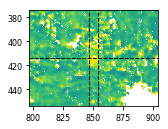

In [109]:
##particle 1 zoom

fig, ax = plt.subplots(figsize=(2.3,2.3)) 

want_im_4 = ax.imshow(image_4, cmap=cmap, interpolation='none', extent=[0, H_um_4, V_um_4, 0], clim = (clo_7,chi_7))

varV_1a = varV_1i * 0.7
varV_1b = (varV_1i + 10) * 0.7
varH_1 = varH_1i * 0.7

ax.axvline(varV_1a, linewidth = 1, linestyle = '--', color = 'k')
ax.axvline(varV_1b, linewidth = 1, linestyle = '--', color = 'k')
ax.axhline(varH_1, linewidth = 1, linestyle = '--', color = 'k')

ax.set_xlim([varV_1a - 50, varV_1b + 50])
ax.set_ylim([varH_1 + 40, varH_1 - 40])

#saving figure as a pdf and svg with index so can change formatting of colors etc without overwriting
savefmt = os.path.join('dataset_29',
                      '{}{}{}{}{{:d}}.{{}}'.format(basename_4, '_1st_', date, '_cursors_um_'))
i = 0
while os.path.exists(savefmt.format(i, 'pdf')):
    i += 1
plt.savefig(savefmt.format(i, 'pdf'), bbox_inches = 'tight')
plt.savefig(savefmt.format(i, 'svg'), bbox_inches = 'tight')

print('varV_1a = %s' %(varV_1a))
print('varV_1b = %s' %(varV_1b))
print('varH_1 = %s' %(varH_1))
print('varV_2a = %s' %(varV_2a))
print('varV_2b = %s' %(varV_2b))
print('varH_2 = %s' %(varH_2))

varV_1a = 847.0
varV_1b = 854.0
varH_1 = 413.7
varV_2a = 829.5
varV_2b = 836.5
varH_2 = 444.5


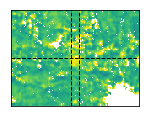

In [110]:
##particle 1 zoom

fig, ax = plt.subplots(figsize=(2.3,2.3)) 

want_im_4 = ax.imshow(image_4, cmap=cmap, interpolation='none', extent=[0, H_um_4, V_um_4, 0], clim = (clo_7,chi_7))

varV_1a = varV_1i * 0.7
varV_1b = (varV_1i + 10) * 0.7
varH_1 = varH_1i * 0.7

ax.axvline(varV_1a, linewidth = 1, linestyle = '--', color = 'k')
ax.axvline(varV_1b, linewidth = 1, linestyle = '--', color = 'k')
ax.axhline(varH_1, linewidth = 1, linestyle = '--', color = 'k')

ax.set_xlim([varV_1a - 50, varV_1b + 50])
ax.set_ylim([varH_1 + 40, varH_1 - 40])

want_im_4.axes.get_xaxis().set_ticks([])
want_im_4.axes.get_yaxis().set_ticks([])

#saving figure as a pdf and svg with index so can change formatting of colors etc without overwriting
savefmt = os.path.join('dataset_29',
                      '{}{}{}{}{{:d}}.{{}}'.format(basename_4, '_notix_1st_', date, '_cursors_um_'))
i = 0
while os.path.exists(savefmt.format(i, 'pdf')):
    i += 1
plt.savefig(savefmt.format(i, 'pdf'), bbox_inches = 'tight')
plt.savefig(savefmt.format(i, 'svg'), bbox_inches = 'tight')

print('varV_1a = %s' %(varV_1a))
print('varV_1b = %s' %(varV_1b))
print('varH_1 = %s' %(varH_1))
print('varV_2a = %s' %(varV_2a))
print('varV_2b = %s' %(varV_2b))
print('varH_2 = %s' %(varH_2))

varV_1a = 847.0
varV_1b = 854.0
varH_1 = 413.7
varV_2a = 829.5
varV_2b = 836.5
varH_2 = 444.5


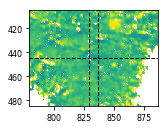

In [111]:
##particle 2 zoom

fig, ax = plt.subplots(figsize=(2.3,2.3)) 

want_im_4 = ax.imshow(image_4, cmap=cmap, interpolation='none', extent=[0, H_um_4, V_um_4, 0], clim = (clo_7,chi_7))

varV_2a = varV_2i * 0.7
varV_2b = (varV_2i + 10) * 0.7
varH_2 = varH_2i * 0.7

ax.axvline(varV_2a, linewidth = 1, linestyle = '--', color = 'k')
ax.axvline(varV_2b, linewidth = 1, linestyle = '--', color = 'k')
ax.axhline(varH_2, linewidth = 1, linestyle = '--', color = 'k')

ax.set_xlim([varV_2a - 50, varV_2b + 50])
ax.set_ylim([varH_2 + 40, varH_2 - 40])

#saving figure as a pdf and svg with index so can change formatting of colors etc without overwriting
savefmt = os.path.join('dataset_29',
                      '{}{}{}{}{{:d}}.{{}}'.format(basename_4, '_2nd_', date, '_cursors_um_'))
i = 0
while os.path.exists(savefmt.format(i, 'pdf')):
    i += 1
plt.savefig(savefmt.format(i, 'pdf'), bbox_inches = 'tight')
plt.savefig(savefmt.format(i, 'svg'), bbox_inches = 'tight')

print('varV_1a = %s' %(varV_1a))
print('varV_1b = %s' %(varV_1b))
print('varH_1 = %s' %(varH_1))
print('varV_2a = %s' %(varV_2a))
print('varV_2b = %s' %(varV_2b))
print('varH_2 = %s' %(varH_2))

varV_1a = 847.0
varV_1b = 854.0
varH_1 = 413.7
varV_2a = 829.5
varV_2b = 836.5
varH_2 = 444.5


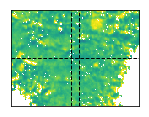

In [112]:
##particle 2 zoom

fig, ax = plt.subplots(figsize=(2.3,2.3)) 

want_im_4 = ax.imshow(image_4, cmap=cmap, interpolation='none', extent=[0, H_um_4, V_um_4, 0], clim = (clo_7,chi_7))

varV_2a = varV_2i * 0.7
varV_2b = (varV_2i + 10) * 0.7
varH_2 = varH_2i * 0.7

ax.axvline(varV_2a, linewidth = 1, linestyle = '--', color = 'k')
ax.axvline(varV_2b, linewidth = 1, linestyle = '--', color = 'k')
ax.axhline(varH_2, linewidth = 1, linestyle = '--', color = 'k')

ax.set_xlim([varV_2a - 50, varV_2b + 50])
ax.set_ylim([varH_2 + 40, varH_2 - 40])

want_im_4.axes.get_xaxis().set_ticks([])
want_im_4.axes.get_yaxis().set_ticks([])

#saving figure as a pdf and svg with index so can change formatting of colors etc without overwriting
savefmt = os.path.join('dataset_29',
                      '{}{}{}{}{{:d}}.{{}}'.format(basename_4, '_notix_2nd_', date, '_cursors_um_'))
i = 0
while os.path.exists(savefmt.format(i, 'pdf')):
    i += 1
plt.savefig(savefmt.format(i, 'pdf'), bbox_inches = 'tight')
plt.savefig(savefmt.format(i, 'svg'), bbox_inches = 'tight')

print('varV_1a = %s' %(varV_1a))
print('varV_1b = %s' %(varV_1b))
print('varH_1 = %s' %(varH_1))
print('varV_2a = %s' %(varV_2a))
print('varV_2b = %s' %(varV_2b))
print('varH_2 = %s' %(varH_2))

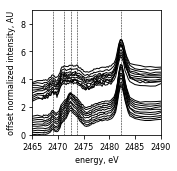

In [113]:
##plot of 10 spectra stepping from left vertical line to right vertical line along the horizontal line for the two particles designated in the image above
plt.figure(figsize=(2.3,2.3)) ##for publication

offset_1=0-0.15 ##giving offset a start value
offset_2=2.5-0.15 ##giving offset a start value
spec_num = 10 ##number of spectra you want plotted and colors needed

for v in range (varV_1i, varV_1i+spec_num):
    offset_1 = offset_1+0.15    ##CHOOSE Y OFFSET HERE
    water = plt.plot(energy, data_4[:,varH_1i,v]+offset_1, 'k', linewidth = 1)        

for v in range (varV_2i, varV_2i+spec_num):
    offset_2 = offset_2+0.15    ##CHOOSE Y OFFSET HERE
    water = plt.plot(energy, data_4[:,varH_2i,v]+offset_2, 'k', linewidth = 1)        

axvline(2469.0, linewidth = 0.5, linestyle = '--', color = 'k')
axvline(2471.2, linewidth = 0.5, linestyle = '--', color = 'k')
axvline(2472.5, linewidth = 0.5, linestyle = '--', color = 'k')
axvline(2473.8, linewidth = 0.5, linestyle = '--', color = 'k')
axvline(2482.2, linewidth = 0.5, linestyle = '--', color = 'k')
    
plt.ylabel('offset normalized intensity, AU')
plt.xlabel('energy, eV')
plt.xlim(2465,2490.001)   #not needed if subsample data above
plt.ylim(0,9)
xticks(np.arange(2465,2490.001, step=5))

##saving figure as a pdf and svg with index
savefmt = os.path.join('dataset_29',
                      '{}{}{}{}{}{}{}{}{}{}{{:d}}.{{}}'.format('spec_', basename_4, '_diff', com_nb+1, com_na+1, '_of_', Nn, '_', date, '_'))
i = 0
while os.path.exists(savefmt.format(i, 'pdf')):
    i += 1
plt.savefig(savefmt.format(i, 'pdf'), bbox_inches = 'tight')
plt.savefig(savefmt.format(i, 'svg'), bbox_inches = 'tight')
plt.show()

H020, pair of particles

In [114]:
##H-020, pair of particles
##particle1
varV_1i = 1050
varH_1i = 790
##particle2
varV_2i = 1008
varH_2i = 750

varV_1a = 735.0
varV_1b = 742.0
varH_1 = 553.0
varV_2a = 705.5999999999999
varV_2b = 712.5999999999999
varH_2 = 525.0


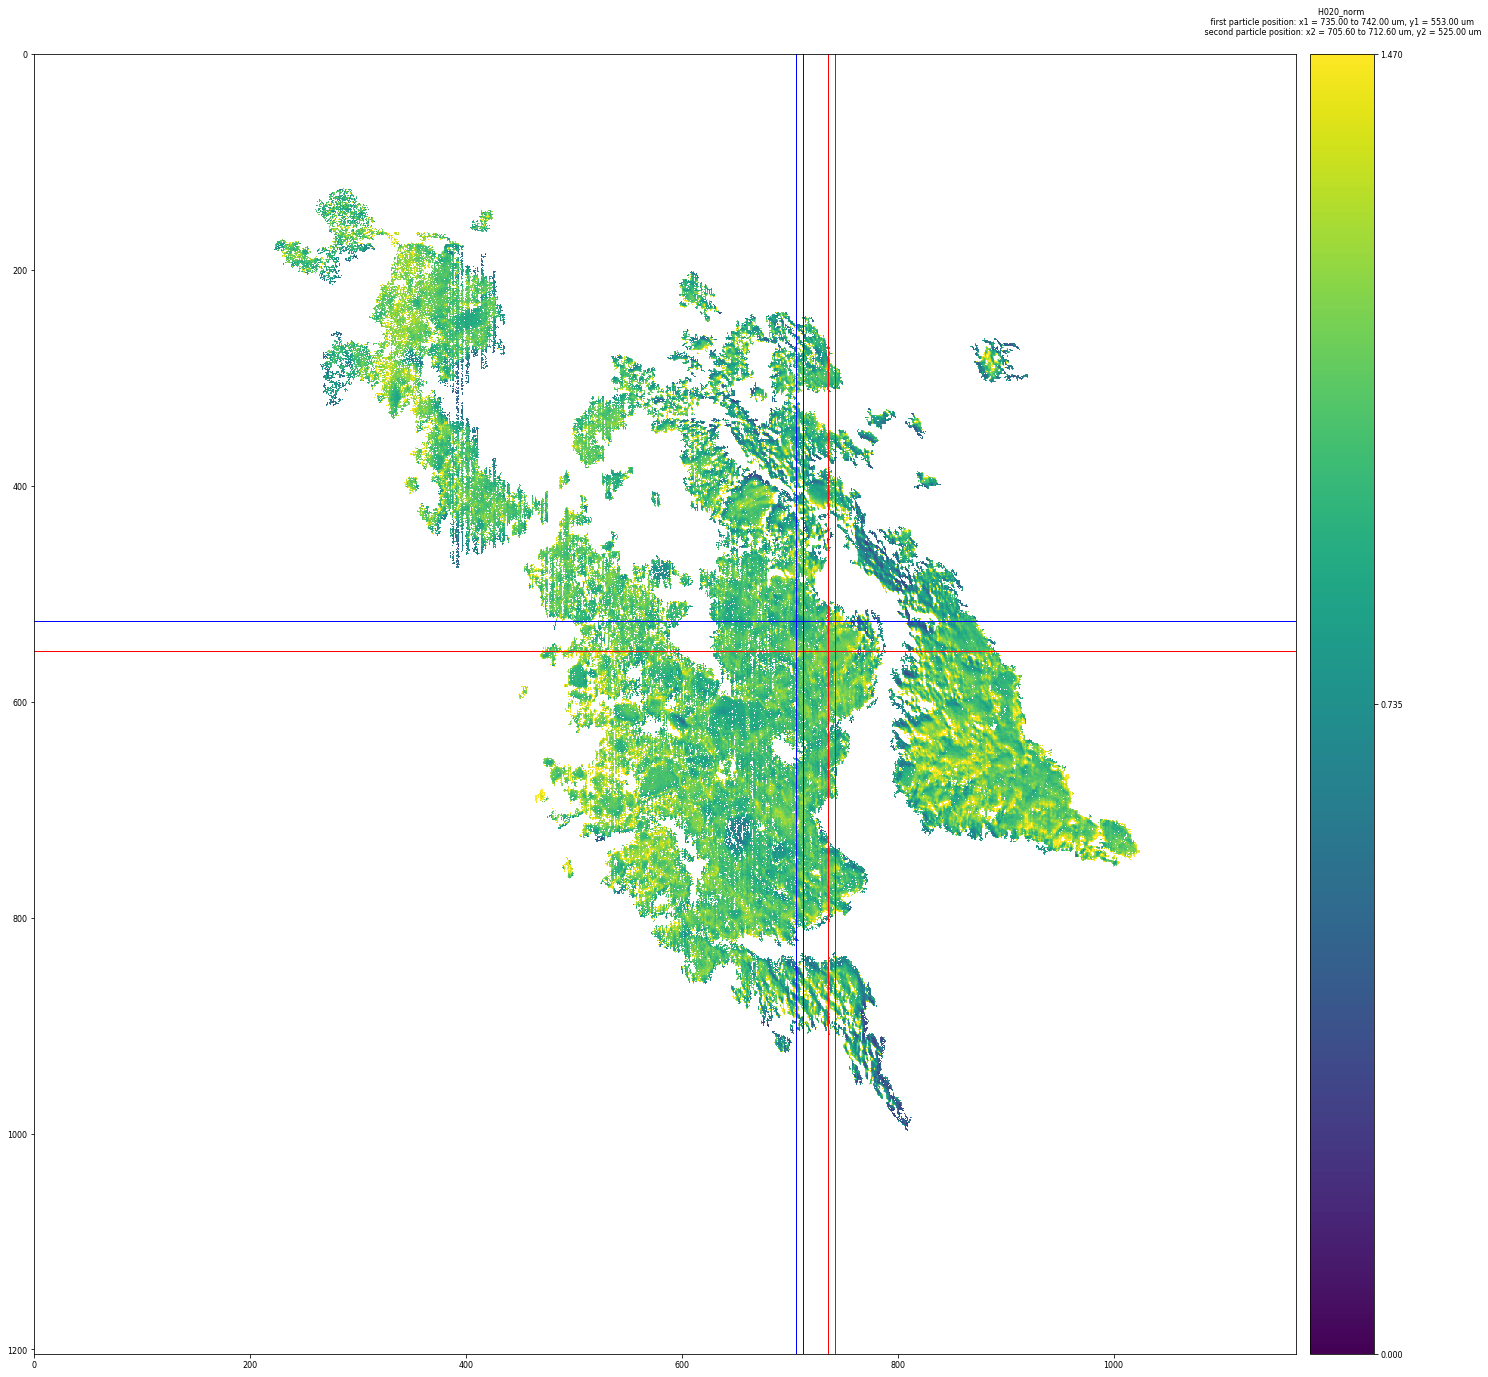

In [115]:
##masked data image in microns x microns to know location of particle
##from which the circles and boxes are drawn in the figures in the main manuscript and SI

fig, ax = plt.subplots(figsize=(24,24)) 

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)

want_im_2 = ax.imshow(image_2, cmap=cmap, interpolation='none', extent=[0, H_um_2, V_um_2, 0], clim = (clo_7,chi_7))
cbar = fig.colorbar(want_im_2, cax=cax, ticks=[clo_7, chi_7/2, chi_7], orientation='vertical')


varV_1a = varV_1i * 0.7
varV_1b = (varV_1i + 10) * 0.7
varH_1 = varH_1i * 0.7

varV_2a = varV_2i * 0.7
varV_2b = (varV_2i + 10) * 0.7
varH_2 = varH_2i * 0.7

plt.title('%s \n first particle position: x1 = %.2f to %.2f um, y1 = %.2f um \n second particle position: x2 = %.2f to %.2f um, y2 = %.2f um'%(basename_2, varV_1a, varV_1b, varH_1, varV_2a, varV_2b, varH_2), pad = 20)

ax.axvline(varV_1a, linewidth = 1, color = 'r')
ax.axvline(varV_1b, linewidth = 1, color = 'r')
ax.axhline(varH_1, linewidth = 1, color = 'r')

ax.axvline(varV_2a, linewidth = 1, color = 'b')
ax.axvline(varV_2b, linewidth = 1, color = 'b')
ax.axhline(varH_2, linewidth = 1, color = 'b')

##saving figure as a pdf and svg with index so can change formatting of colors etc without overwriting
savefmt = os.path.join('dataset_29',
                      '{}{}{}{}{{:d}}.{{}}'.format(basename_2, '_', date, '_cursors_um_'))
i = 0
while os.path.exists(savefmt.format(i, 'pdf')):
    i += 1
plt.savefig(savefmt.format(i, 'pdf'), bbox_inches = 'tight')
plt.savefig(savefmt.format(i, 'svg'), bbox_inches = 'tight')

print('varV_1a = %s' %(varV_1a))
print('varV_1b = %s' %(varV_1b))
print('varH_1 = %s' %(varH_1))
print('varV_2a = %s' %(varV_2a))
print('varV_2b = %s' %(varV_2b))
print('varH_2 = %s' %(varH_2))

varV_1a = 735.0
varV_1b = 742.0
varH_1 = 553.0
varV_2a = 705.5999999999999
varV_2b = 712.5999999999999
varH_2 = 525.0


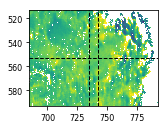

In [116]:
##particle 1 zoom

fig, ax = plt.subplots(figsize=(2.3,2.3)) 

want_im_2 = ax.imshow(image_2, cmap=cmap, interpolation='none', extent=[0, H_um_2, V_um_2, 0], clim = (clo_7,chi_7))

varV_1a = varV_1i * 0.7
varV_1b = (varV_1i + 10) * 0.7
varH_1 = varH_1i * 0.7

ax.axvline(varV_1a, linewidth = 1, linestyle = '--', color = 'k')
ax.axvline(varV_1b, linewidth = 1, linestyle = '--', color = 'k')
ax.axhline(varH_1, linewidth = 1, linestyle = '--', color = 'k')

ax.set_xlim([varV_1a - 50, varV_1b + 50])
ax.set_ylim([varH_1 + 40, varH_1 - 40])

#saving figure as a pdf and svg with index so can change formatting of colors etc without overwriting
savefmt = os.path.join('dataset_29',
                      '{}{}{}{}{{:d}}.{{}}'.format(basename_2, '_1st_', date, '_cursors_um_'))
i = 0
while os.path.exists(savefmt.format(i, 'pdf')):
    i += 1
plt.savefig(savefmt.format(i, 'pdf'), bbox_inches = 'tight')
plt.savefig(savefmt.format(i, 'svg'), bbox_inches = 'tight')

print('varV_1a = %s' %(varV_1a))
print('varV_1b = %s' %(varV_1b))
print('varH_1 = %s' %(varH_1))
print('varV_2a = %s' %(varV_2a))
print('varV_2b = %s' %(varV_2b))
print('varH_2 = %s' %(varH_2))

varV_1a = 735.0
varV_1b = 742.0
varH_1 = 553.0
varV_2a = 705.5999999999999
varV_2b = 712.5999999999999
varH_2 = 525.0


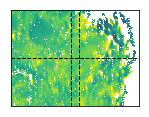

In [117]:
##particle 1 zoom

fig, ax = plt.subplots(figsize=(2.3,2.3)) 

want_im_2 = ax.imshow(image_2, cmap=cmap, interpolation='none', extent=[0, H_um_2, V_um_2, 0], clim = (clo_7,chi_7))

varV_1a = varV_1i * 0.7
varV_1b = (varV_1i + 10) * 0.7
varH_1 = varH_1i * 0.7

ax.axvline(varV_1a, linewidth = 1, linestyle = '--', color = 'k')
ax.axvline(varV_1b, linewidth = 1, linestyle = '--', color = 'k')
ax.axhline(varH_1, linewidth = 1, linestyle = '--', color = 'k')

ax.set_xlim([varV_1a - 50, varV_1b + 50])
ax.set_ylim([varH_1 + 40, varH_1 - 40])

want_im_2.axes.get_xaxis().set_ticks([])
want_im_2.axes.get_yaxis().set_ticks([])

#saving figure as a pdf and svg with index so can change formatting of colors etc without overwriting
savefmt = os.path.join('dataset_29',
                      '{}{}{}{}{{:d}}.{{}}'.format(basename_2, '_notix_1st_', date, '_cursors_um_'))
i = 0
while os.path.exists(savefmt.format(i, 'pdf')):
    i += 1
plt.savefig(savefmt.format(i, 'pdf'), bbox_inches = 'tight')
plt.savefig(savefmt.format(i, 'svg'), bbox_inches = 'tight')

print('varV_1a = %s' %(varV_1a))
print('varV_1b = %s' %(varV_1b))
print('varH_1 = %s' %(varH_1))
print('varV_2a = %s' %(varV_2a))
print('varV_2b = %s' %(varV_2b))
print('varH_2 = %s' %(varH_2))

varV_1a = 735.0
varV_1b = 742.0
varH_1 = 553.0
varV_2a = 705.5999999999999
varV_2b = 712.5999999999999
varH_2 = 525.0


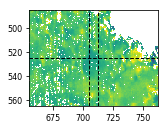

In [118]:
##particle 2 zoom

fig, ax = plt.subplots(figsize=(2.3,2.3)) 

want_im_2 = ax.imshow(image_2, cmap=cmap, interpolation='none', extent=[0, H_um_2, V_um_2, 0], clim = (clo_7,chi_7))

varV_2a = varV_2i * 0.7
varV_2b = (varV_2i + 10) * 0.7
varH_2 = varH_2i * 0.7

ax.axvline(varV_2a, linewidth = 1, linestyle = '--', color = 'k')
ax.axvline(varV_2b, linewidth = 1, linestyle = '--', color = 'k')
ax.axhline(varH_2, linewidth = 1, linestyle = '--', color = 'k')

ax.set_xlim([varV_2a - 50, varV_2b + 50])
ax.set_ylim([varH_2 + 40, varH_2 - 40])

#saving figure as a pdf and svg with index so can change formatting of colors etc without overwriting
savefmt = os.path.join('dataset_29',
                      '{}{}{}{}{{:d}}.{{}}'.format(basename_2, '_2nd_', date, '_cursors_um_'))
i = 0
while os.path.exists(savefmt.format(i, 'pdf')):
    i += 1
plt.savefig(savefmt.format(i, 'pdf'), bbox_inches = 'tight')
plt.savefig(savefmt.format(i, 'svg'), bbox_inches = 'tight')

print('varV_1a = %s' %(varV_1a))
print('varV_1b = %s' %(varV_1b))
print('varH_1 = %s' %(varH_1))
print('varV_2a = %s' %(varV_2a))
print('varV_2b = %s' %(varV_2b))
print('varH_2 = %s' %(varH_2))

varV_1a = 735.0
varV_1b = 742.0
varH_1 = 553.0
varV_2a = 705.5999999999999
varV_2b = 712.5999999999999
varH_2 = 525.0


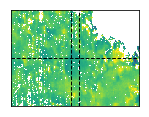

In [119]:
##particle 2 zoom

fig, ax = plt.subplots(figsize=(2.3,2.3)) 

want_im_2 = ax.imshow(image_2, cmap=cmap, interpolation='none', extent=[0, H_um_2, V_um_2, 0], clim = (clo_7,chi_7))

varV_2a = varV_2i * 0.7
varV_2b = (varV_2i + 10) * 0.7
varH_2 = varH_2i * 0.7

ax.axvline(varV_2a, linewidth = 1, linestyle = '--', color = 'k')
ax.axvline(varV_2b, linewidth = 1, linestyle = '--', color = 'k')
ax.axhline(varH_2, linewidth = 1, linestyle = '--', color = 'k')

ax.set_xlim([varV_2a - 50, varV_2b + 50])
ax.set_ylim([varH_2 + 40, varH_2 - 40])

want_im_2.axes.get_xaxis().set_ticks([])
want_im_2.axes.get_yaxis().set_ticks([])

#saving figure as a pdf and svg with index so can change formatting of colors etc without overwriting
savefmt = os.path.join('dataset_29',
                      '{}{}{}{}{{:d}}.{{}}'.format(basename_2, '_notix_2nd_', date, '_cursors_um_'))
i = 0
while os.path.exists(savefmt.format(i, 'pdf')):
    i += 1
plt.savefig(savefmt.format(i, 'pdf'), bbox_inches = 'tight')
plt.savefig(savefmt.format(i, 'svg'), bbox_inches = 'tight')

print('varV_1a = %s' %(varV_1a))
print('varV_1b = %s' %(varV_1b))
print('varH_1 = %s' %(varH_1))
print('varV_2a = %s' %(varV_2a))
print('varV_2b = %s' %(varV_2b))
print('varH_2 = %s' %(varH_2))

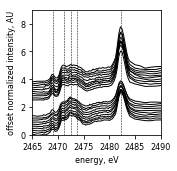

In [120]:
##plot of 10 spectra stepping from left vertical line to right vertical line along the horizontal line for the two particles designated in the image above
plt.figure(figsize=(2.3,2.3)) ##for publication

offset_1=0-0.15 ##giving offset a start value
offset_2=2.5-0.15 ##giving offset a start value
spec_num = 10 ##number of spectra you want plotted and colors needed

for v in range (varV_1i, varV_1i+spec_num):
    offset_1 = offset_1+0.15    ##CHOOSE Y OFFSET HERE
    water = plt.plot(energy, data_2[:,varH_1i,v]+offset_1, 'k', linewidth = 1)        

for v in range (varV_2i, varV_2i+spec_num):
    offset_2 = offset_2+0.15    ##CHOOSE Y OFFSET HERE
    water = plt.plot(energy, data_2[:,varH_2i,v]+offset_2, 'k', linewidth = 1)        

axvline(2469.0, linewidth = 0.5, linestyle = '--', color = 'k')
axvline(2471.2, linewidth = 0.5, linestyle = '--', color = 'k')
axvline(2472.5, linewidth = 0.5, linestyle = '--', color = 'k')
axvline(2473.8, linewidth = 0.5, linestyle = '--', color = 'k')
axvline(2482.2, linewidth = 0.5, linestyle = '--', color = 'k')
    
plt.ylabel('offset normalized intensity, AU')
plt.xlabel('energy, eV')
plt.xlim(2465,2490.001)   #not needed if subsample data above
plt.ylim(0,9)
xticks(np.arange(2465,2490.001, step=5))

##saving figure as a pdf and svg with index
savefmt = os.path.join('dataset_29',
                      '{}{}{}{}{}{}{}{}{}{}{{:d}}.{{}}'.format('spec_', basename_2, '_diff', com_nb+1, com_na+1, '_of_', Nn, '_', date, '_'))
i = 0
while os.path.exists(savefmt.format(i, 'pdf')):
    i += 1
plt.savefig(savefmt.format(i, 'pdf'), bbox_inches = 'tight')
plt.savefig(savefmt.format(i, 'svg'), bbox_inches = 'tight')
plt.show()

### continue to sheet '08_2017paint_Treatment-I...'